##ロジスティック回帰を使用したフィッシング検出器

In [1]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/dataset.csv

--2021-09-04 02:39:13--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/dataset.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/dataset.csv [following]
--2021-09-04 02:39:13--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 788720 (770K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>] 770.23K  --.-KB/s    in 0.06s   

2021-09-04 02:39:13 (13.2 MB/s) - ‘dataset.csv’ saved [788720/788720]



In [2]:
!pip install optuna

     |████████████████████████████████| 302 kB 3.2 MB/s 
     |████████████████████████████████| 80 kB 6.0 MB/s 
     |████████████████████████████████| 208 kB 44.0 MB/s 
     |████████████████████████████████| 75 kB 2.9 MB/s 
     |████████████████████████████████| 111 kB 37.1 MB/s 
     |████████████████████████████████| 49 kB 2.9 MB/s 
     |████████████████████████████████| 141 kB 48.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=1d1f5cc7f58d556d060516f37a75e5a6fb0cec7bda707be9b3c55cb3bd98baa5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate

training_data = np.genfromtxt('dataset.csv', delimiter=',', dtype=np.int32)

In [4]:
X = training_data[:,:-1]
y = training_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

classifier = LogisticRegression(solver='lbfgs')

# 検出器を訓練する。
classifier.fit(X_train, y_train)
# 予測させる。
predictions = classifier.predict(X_test)

# このフィッシング検出器の精度を出力させる。
accuracy = 100.0 * accuracy_score(y_test, predictions)
print("The accuracy of your Logistic Regression on testing data is: {}".format(accuracy))

The accuracy of your Logistic Regression on testing data is: 92.22071460877432


In [5]:
from sklearn.model_selection import cross_val_score

# 交差検証(5分割)による汎化性能の評価
scores = cross_val_score(classifier, X, y, cv=5)
# 評価結果の出力
print("Evaluated score by cross-validation(k=5): {}".format(100 * scores.mean()))

Evaluated score by cross-validation(k=5): 92.2568973315242


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

X = training_data[:,:-1]
y = training_data[:, -1]

class Objective:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ターゲットのハイパーパラメータの設定
        params = {
            # 最適化に使用するアルゴリズムの候補をカテゴリとして指定
            'solver' : trial.suggest_categorical('solver', 
                                                 ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
            # ペナルティの探索幅に0.0001から10までを指定
            'C': trial.suggest_loguniform('C', 0.0001, 10),
            # ソルバーが収束するまでの最大反復回数
            'max_iter': trial.suggest_int('max_iter', 100, 100000)
            }

        model = LogisticRegression(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

# ハイパーパラメータの探索
objective = Objective(X, y)
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=60)
# ベストのパラメータの出力
print('params:', study.best_params)

[I 2021-09-04 02:39:27,018] A new study created in memory with name: no-name-a6a9812b-5bdf-4ad9-aa89-04bc95071b80
[I 2021-09-04 02:39:28,487] Trial 0 finished with value: 0.922568973315242 and parameters: {'solver': 'lbfgs', 'C': 0.8670541209184646, 'max_iter': 20584}. Best is trial 0 with value: 0.922568973315242.
[I 2021-09-04 02:39:29,351] Trial 1 finished with value: 0.9227498869289914 and parameters: {'solver': 'sag', 'C': 3.24396874394686, 'max_iter': 78882}. Best is trial 1 with value: 0.9227498869289914.
[I 2021-09-04 02:39:29,570] Trial 2 finished with value: 0.8961555857078245 and parameters: {'solver': 'lbfgs', 'C': 0.00024398226911983125, 'max_iter': 67980}. Best is trial 1 with value: 0.9227498869289914.
[I 2021-09-04 02:39:29,928] Trial 3 finished with value: 0.9233830845771145 and parameters: {'solver': 'saga', 'C': 0.25250706526333383, 'max_iter': 13168}. Best is trial 3 with value: 0.9233830845771145.
[I 2021-09-04 02:39:30,383] Trial 4 finished with value: 0.923744911

params: {'solver': 'saga', 'C': 0.041845981914747005, 'max_iter': 70583}


In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# ハイパーパラメータ探索で特定した値を設定(このパラメータは参考値)
params = {'solver': 'newton-cg', 'C': 0.04212261555400658, 'max_iter': 26018}

model = LogisticRegression(**params)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# 正解率の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
# 混同行列の出力
print(confusion_matrix(y_test, pred))

Accurary: 92.31117 %
[[ 872   99]
 [  71 1169]]


In [8]:
from sklearn.metrics import precision_score, recall_score

# 精度の確認
print("Precision: {:.5f} %".format(100 * precision_score(y_test, pred, average="macro")))
# 再現率の確認
print("Recall: {:.5f} %".format(100 * recall_score(y_test, pred, average="macro")))

Precision: 92.33163 %
Recall: 92.03926 %


##決定木を使用したフィッシング検出器

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

X = training_data[:,:-1]
y = training_data[:, -1]

class Objective_DTC:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ターゲットのハイパーパラメータの設定
        params = {
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
            'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
            'max_depth': trial.suggest_int('max_depth', 2, 64)
            }

        model = DecisionTreeClassifier(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

objective = Objective_DTC(X, y)
study = optuna.create_study(direction='maximize')
# timeoutに60を指定し、最大で1分間探索させる
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2021-09-04 02:40:27,245] A new study created in memory with name: no-name-e76a6c03-cfb6-4094-9493-e624dc27a378
[I 2021-09-04 02:40:27,435] Trial 0 finished with value: 0.893441881501583 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_features': 'log2', 'min_samples_split': 56, 'max_depth': 25}. Best is trial 0 with value: 0.893441881501583.
[I 2021-09-04 02:40:27,591] Trial 1 finished with value: 0.9455450022614201 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_features': 'sqrt', 'min_samples_split': 5, 'max_depth': 54}. Best is trial 1 with value: 0.9455450022614201.
[I 2021-09-04 02:40:27,745] Trial 2 finished with value: 0.9257349615558571 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': 'log2', 'min_samples_split': 7, 'max_depth': 61}. Best is trial 1 with value: 0.9455450022614201.
[I 2021-09-04 02:40:27,900] Trial 3 finished with value: 0.908819538670285 and parameters: {'criterion': 'entropy', 'splitter': 'best', 

params: {'criterion': 'gini', 'splitter': 'random', 'max_features': 'auto', 'min_samples_split': 2, 'max_depth': 62}


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# ハイパーパラメータ探索で特定した値を設定(このパラメータは参考値)
params={'criterion': 'entropy', 'splitter': 'best', 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 36}

model = DecisionTreeClassifier(**params)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# 正解率の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
# 精度の出力
print("Precision: {:.5f} %".format(100 * precision_score(y_test, pred, average="macro")))
# 再現率の出力
print("Recall: {:.5f} %".format(100 * recall_score(y_test, pred, average="macro")))
# 混同行列の出力
print(confusion_matrix(y_test, pred))

Accurary: 95.29625 %
Precision: 95.19985 %
Recall: 95.25909 %
[[ 922   49]
 [  55 1185]]


### tf-idfを使った迷惑メール検出

In [11]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/enron1.zip

--2021-09-04 02:41:27--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/enron1.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/enron1.zip [following]
--2021-09-04 02:41:27--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/enron1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3597958 (3.4M) [application/zip]
Saving to: ‘enron1.zip’

enron1.zip          100%[===================>]   3.43M  --.-KB/s    in 0.09s   

2021-09-04 02:41:28 (39.4 MB/s) - ‘enron1.zip’ saved [3597958/3597958]



In [12]:
!unzip -q enron1.zip

In [13]:
!ls ./enron1/ham

0001.1999-12-10.farmer.ham.txt	2561.2000-10-17.farmer.ham.txt
0002.1999-12-13.farmer.ham.txt	2563.2000-10-17.farmer.ham.txt
0003.1999-12-14.farmer.ham.txt	2564.2000-10-17.farmer.ham.txt
0004.1999-12-14.farmer.ham.txt	2565.2000-10-18.farmer.ham.txt
0005.1999-12-14.farmer.ham.txt	2567.2000-10-18.farmer.ham.txt
0007.1999-12-14.farmer.ham.txt	2569.2000-10-18.farmer.ham.txt
0009.1999-12-14.farmer.ham.txt	2571.2000-10-18.farmer.ham.txt
0010.1999-12-14.farmer.ham.txt	2572.2000-10-18.farmer.ham.txt
0011.1999-12-14.farmer.ham.txt	2573.2000-10-18.farmer.ham.txt
0012.1999-12-14.farmer.ham.txt	2574.2000-10-18.farmer.ham.txt
0013.1999-12-14.farmer.ham.txt	2576.2000-10-18.farmer.ham.txt
0014.1999-12-15.farmer.ham.txt	2577.2000-10-18.farmer.ham.txt
0015.1999-12-15.farmer.ham.txt	2578.2000-10-18.farmer.ham.txt
0016.1999-12-15.farmer.ham.txt	2579.2000-10-18.farmer.ham.txt
0019.1999-12-15.farmer.ham.txt	2582.2000-10-18.farmer.ham.txt
0020.1999-12-15.farmer.ham.txt	2584.2000-10-18.farmer.ham.txt
0021.199

In [14]:
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate
import os
import codecs

In [15]:
def init_lists(folder):
    key_list = []
    file_list = os.listdir(folder)
    for filename in file_list:
        f = codecs.open(folder + filename, 'r', encoding='utf-8', errors='ignore')
        key_list.append(f.read())
    f.close()
    return key_list

all_mails = list()
spam = init_lists('./enron1/spam/')
ham = init_lists('./enron1/ham/')
# リストにした迷惑メール(spam)と、通常のメール(ham)を別のリストにコピーし、迷惑メールの場合はラベルを1に、そうでない場合は0にする
all_mails = [(mail, '1') for mail in spam]
all_mails += [(mail, '0') for mail in ham]

In [16]:
import pandas as pd
# DataFrameにメールの文面とラベルを列に設定してロードする
df = pd.DataFrame(all_mails, columns=['text', 'label'])

In [17]:
df

,text,label
0,"Subject: kenney song\r\nsat , 24 apr 2004 09 :...",1
1,Subject: it ' s not working like it used to ?\...,1
2,Subject: prissy abe dainty bifocal kalmia coar...,1
3,Subject: cailis for cheap !\r\nnew coalos soft...,1
4,Subject: outstanding rx\r\nhelp blastocoel pro...,1
...,...,...
5167,Subject: please note my new email address\r\ne...,0
5168,Subject: aspect resources\r\nconfirmation :\r\...,0
5169,Subject: conoco supply cuts on oasis 5 / 21 - ...,0
5170,"Subject: hpl nom for january 24 , 2001\r\n( se...",0


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizerを初期化する。stop_wordsにenglishを指定し、一般的な単語を除外する
tfidf = TfidfVectorizer(stop_words="english", lowercase=False)

X = tfidf.fit_transform(df['text'])
column_names = tfidf.get_feature_names()

# Xにベクトル化した値を整形して代入
X = pd.DataFrame(X.toarray())
X = X.astype('float')
# カラム名を設定
X.columns = column_names
y = df['label'].astype('float')

In [19]:
X

,00,000,0000,000000,000000000002858,000000000049773,000080,000099,0001,00018,00020608,0004,0005,0008,001,0010,001001,0012,001452,002,0022,00221,0025,0027,0028,0029,00298,003,0030,003002,0031,0033,0038,004,0042,0043,0044,0045,0046,0047,...,zv,zve,zvikydqu,zvjc,zvp,zvrkxjmex,zvx,zw,zwallet,zwdm,zwftnqlp,zwiers,zwmdjvr,zwoegen,zwu,zxaghur,zxgwvpiadobe,zxgwvpihere,zxgwvpiimg,zxgwvpimacromedia,zxgwvpimicrosoft,zxgwvpinorton,zxjcxz,zxklh,zxzmcnbf,zyban,zyjvit,zykfe,zyl,zynsdirnh,zynve,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzn,zzo,zzocb,zzso,zzsyt
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5168,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5169,0.0,0.104929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5170,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train, num_boost_round=100)

# ハイパーパラメータ探索の実行
tuner.run()

[I 2021-09-04 02:41:37,449] A new study created in memory with name: no-name-7a6f72d9-d7e3-49f4-86d4-41e3f71a1e52
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.535056 + 0.00180415
[2]	cv_agg's binary_logloss: 0.483765 + 0.00296456
[3]	cv_agg's binary_logloss: 0.441085 + 0.00364481
[4]	cv_agg's binary_logloss: 0.405134 + 0.00444022
[5]	cv_agg's binary_logloss: 0.372832 + 0.00509767
[6]	cv_agg's binary_logloss: 0.345264 + 0.00567616
[7]	cv_agg's binary_logloss: 0.32216 + 0.00625259
[8]	cv_agg's binary_logloss: 0.299993 + 0.00604763
[9]	cv_agg's binary_logloss: 0.28174 + 0.00659546
[10]	cv_agg's binary_logloss: 0.264182 + 0.00685239
[11]	cv_agg's binary_logloss: 0.248836 + 0.00742024
[12]	cv_agg's binary_logloss: 0.236016 + 0.00723116
[13]	cv_agg's binary_logloss: 0.222982 + 0.0070483
[14]	cv_agg's binary_logloss: 0.212237 + 0.00744892
[15]	cv_agg's binary_logloss: 0.2021 + 0.00764213
[16]	cv_agg's binary_logloss: 0.192376 + 0.00750775
[17]	cv_agg's binary_logloss: 0.185066 + 0.00721384
[18]	cv_agg's binary_logloss: 0.177283 + 0.00759305
[19]	cv_agg's binary_logloss: 0.170786 + 0.00783191
[20]	cv_agg's binary_loglo

feature_fraction, val_score: 0.072068:  14%|#4        | 1/7 [00:19<01:56, 19.48s/it]

[1]	cv_agg's binary_logloss: 0.534732 + 0.00246131
[2]	cv_agg's binary_logloss: 0.481566 + 0.00372244
[3]	cv_agg's binary_logloss: 0.439292 + 0.00400977
[4]	cv_agg's binary_logloss: 0.403264 + 0.00475384
[5]	cv_agg's binary_logloss: 0.370141 + 0.00542974
[6]	cv_agg's binary_logloss: 0.341473 + 0.00547078
[7]	cv_agg's binary_logloss: 0.318845 + 0.0062474
[8]	cv_agg's binary_logloss: 0.296972 + 0.00619586
[9]	cv_agg's binary_logloss: 0.278439 + 0.00685831
[10]	cv_agg's binary_logloss: 0.26176 + 0.00703576
[11]	cv_agg's binary_logloss: 0.247763 + 0.00751069
[12]	cv_agg's binary_logloss: 0.234641 + 0.00719783
[13]	cv_agg's binary_logloss: 0.221167 + 0.0073509
[14]	cv_agg's binary_logloss: 0.209659 + 0.00752834
[15]	cv_agg's binary_logloss: 0.200178 + 0.00743614
[16]	cv_agg's binary_logloss: 0.190787 + 0.00755804
[17]	cv_agg's binary_logloss: 0.183036 + 0.0077302
[18]	cv_agg's binary_logloss: 0.175443 + 0.00740715
[19]	cv_agg's binary_logloss: 0.168456 + 0.007179
[20]	cv_agg's binary_loglos

feature_fraction, val_score: 0.072068:  29%|##8       | 2/7 [00:40<01:41, 20.30s/it]

[1]	cv_agg's binary_logloss: 0.535073 + 0.00196905
[2]	cv_agg's binary_logloss: 0.484214 + 0.00243796
[3]	cv_agg's binary_logloss: 0.442369 + 0.00270846
[4]	cv_agg's binary_logloss: 0.40686 + 0.00395879
[5]	cv_agg's binary_logloss: 0.375136 + 0.00457586
[6]	cv_agg's binary_logloss: 0.348199 + 0.00483694
[7]	cv_agg's binary_logloss: 0.326062 + 0.0059159
[8]	cv_agg's binary_logloss: 0.305046 + 0.0062443
[9]	cv_agg's binary_logloss: 0.285609 + 0.0059996
[10]	cv_agg's binary_logloss: 0.267335 + 0.00613917
[11]	cv_agg's binary_logloss: 0.252149 + 0.00673239
[12]	cv_agg's binary_logloss: 0.239743 + 0.00648477
[13]	cv_agg's binary_logloss: 0.22651 + 0.00665377
[14]	cv_agg's binary_logloss: 0.215076 + 0.00653582
[15]	cv_agg's binary_logloss: 0.205108 + 0.00669125
[16]	cv_agg's binary_logloss: 0.195717 + 0.0069052
[17]	cv_agg's binary_logloss: 0.187754 + 0.00712888
[18]	cv_agg's binary_logloss: 0.180373 + 0.00722464
[19]	cv_agg's binary_logloss: 0.174279 + 0.00757942
[20]	cv_agg's binary_loglos

feature_fraction, val_score: 0.070774:  43%|####2     | 3/7 [01:01<01:22, 20.52s/it]

[100]	cv_agg's binary_logloss: 0.0707737 + 0.0136699
[1]	cv_agg's binary_logloss: 0.534043 + 0.00184346
[2]	cv_agg's binary_logloss: 0.480306 + 0.0026791
[3]	cv_agg's binary_logloss: 0.43632 + 0.00379096
[4]	cv_agg's binary_logloss: 0.398648 + 0.00491762
[5]	cv_agg's binary_logloss: 0.366726 + 0.00517539
[6]	cv_agg's binary_logloss: 0.33899 + 0.00481874
[7]	cv_agg's binary_logloss: 0.314987 + 0.00578679
[8]	cv_agg's binary_logloss: 0.293751 + 0.00663403
[9]	cv_agg's binary_logloss: 0.275487 + 0.00656555
[10]	cv_agg's binary_logloss: 0.259478 + 0.00667081
[11]	cv_agg's binary_logloss: 0.245227 + 0.00743314
[12]	cv_agg's binary_logloss: 0.231637 + 0.00660992
[13]	cv_agg's binary_logloss: 0.219652 + 0.00646359
[14]	cv_agg's binary_logloss: 0.208627 + 0.00624917
[15]	cv_agg's binary_logloss: 0.198889 + 0.00679382
[16]	cv_agg's binary_logloss: 0.190096 + 0.0072267
[17]	cv_agg's binary_logloss: 0.182134 + 0.00694803
[18]	cv_agg's binary_logloss: 0.174409 + 0.00732607
[19]	cv_agg's binary_log

feature_fraction, val_score: 0.070774:  57%|#####7    | 4/7 [01:24<01:05, 21.82s/it]

[100]	cv_agg's binary_logloss: 0.0729326 + 0.0148263
[1]	cv_agg's binary_logloss: 0.543423 + 0.00134907
[2]	cv_agg's binary_logloss: 0.498935 + 0.00201491
[3]	cv_agg's binary_logloss: 0.461989 + 0.00261588
[4]	cv_agg's binary_logloss: 0.422228 + 0.0029442
[5]	cv_agg's binary_logloss: 0.388242 + 0.00359541
[6]	cv_agg's binary_logloss: 0.361869 + 0.00377284
[7]	cv_agg's binary_logloss: 0.340254 + 0.00411082
[8]	cv_agg's binary_logloss: 0.318298 + 0.00381865
[9]	cv_agg's binary_logloss: 0.299547 + 0.00449278
[10]	cv_agg's binary_logloss: 0.282033 + 0.00496587
[11]	cv_agg's binary_logloss: 0.265134 + 0.00553453
[12]	cv_agg's binary_logloss: 0.252534 + 0.00584936
[13]	cv_agg's binary_logloss: 0.23868 + 0.00641129
[14]	cv_agg's binary_logloss: 0.22761 + 0.00659808
[15]	cv_agg's binary_logloss: 0.217392 + 0.00620077
[16]	cv_agg's binary_logloss: 0.208341 + 0.00647138
[17]	cv_agg's binary_logloss: 0.19949 + 0.00658549
[18]	cv_agg's binary_logloss: 0.191177 + 0.00632052
[19]	cv_agg's binary_log

feature_fraction, val_score: 0.069504:  71%|#######1  | 5/7 [01:40<00:39, 19.63s/it]

[99]	cv_agg's binary_logloss: 0.069529 + 0.0116838
[100]	cv_agg's binary_logloss: 0.0695044 + 0.0115708
[1]	cv_agg's binary_logloss: 0.536747 + 0.00225792
[2]	cv_agg's binary_logloss: 0.48982 + 0.00266702
[3]	cv_agg's binary_logloss: 0.450923 + 0.00354011
[4]	cv_agg's binary_logloss: 0.413446 + 0.0041697
[5]	cv_agg's binary_logloss: 0.38119 + 0.00421529
[6]	cv_agg's binary_logloss: 0.353003 + 0.0043466
[7]	cv_agg's binary_logloss: 0.331138 + 0.00450451
[8]	cv_agg's binary_logloss: 0.309317 + 0.00472729
[9]	cv_agg's binary_logloss: 0.290916 + 0.00532649
[10]	cv_agg's binary_logloss: 0.273219 + 0.00596517
[11]	cv_agg's binary_logloss: 0.257653 + 0.00700592
[12]	cv_agg's binary_logloss: 0.245144 + 0.00696765
[13]	cv_agg's binary_logloss: 0.231884 + 0.00749848
[14]	cv_agg's binary_logloss: 0.219944 + 0.00771861
[15]	cv_agg's binary_logloss: 0.209684 + 0.0073461
[16]	cv_agg's binary_logloss: 0.200213 + 0.00759265
[17]	cv_agg's binary_logloss: 0.192217 + 0.00785762
[18]	cv_agg's binary_loglo

feature_fraction, val_score: 0.069504:  86%|########5 | 6/7 [01:57<00:18, 18.79s/it]

[100]	cv_agg's binary_logloss: 0.0699266 + 0.0144579
[1]	cv_agg's binary_logloss: 0.534064 + 0.0010614
[2]	cv_agg's binary_logloss: 0.479712 + 0.00256237
[3]	cv_agg's binary_logloss: 0.436349 + 0.00318207
[4]	cv_agg's binary_logloss: 0.399359 + 0.00386379
[5]	cv_agg's binary_logloss: 0.366854 + 0.00446423
[6]	cv_agg's binary_logloss: 0.339043 + 0.0050019
[7]	cv_agg's binary_logloss: 0.316733 + 0.00612312
[8]	cv_agg's binary_logloss: 0.295737 + 0.00623786
[9]	cv_agg's binary_logloss: 0.277357 + 0.00653098
[10]	cv_agg's binary_logloss: 0.260082 + 0.00666554
[11]	cv_agg's binary_logloss: 0.246116 + 0.00663802
[12]	cv_agg's binary_logloss: 0.233082 + 0.00694614
[13]	cv_agg's binary_logloss: 0.221171 + 0.0075044
[14]	cv_agg's binary_logloss: 0.210508 + 0.00778887
[15]	cv_agg's binary_logloss: 0.200722 + 0.00818135
[16]	cv_agg's binary_logloss: 0.191478 + 0.00814006
[17]	cv_agg's binary_logloss: 0.184033 + 0.00771948
[18]	cv_agg's binary_logloss: 0.1757 + 0.00737158
[19]	cv_agg's binary_logl

num_leaves, val_score: 0.069504:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273485
[3]	cv_agg's binary_logloss: 0.460723 + 0.00348868
[4]	cv_agg's binary_logloss: 0.420934 + 0.00396037
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478038
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504726
[7]	cv_agg's binary_logloss: 0.338258 + 0.00522821
[8]	cv_agg's binary_logloss: 0.316156 + 0.00531936
[9]	cv_agg's binary_logloss: 0.29763 + 0.00599519
[10]	cv_agg's binary_logloss: 0.279677 + 0.00616998
[11]	cv_agg's binary_logloss: 0.262522 + 0.00677382
[12]	cv_agg's binary_logloss: 0.249519 + 0.00671507
[13]	cv_agg's binary_logloss: 0.235289 + 0.00735835
[14]	cv_agg's binary_logloss: 0.224254 + 0.0075818
[15]	cv_agg's binary_logloss: 0.213875 + 0.00739877
[16]	cv_agg's binary_logloss: 0.204661 + 0.00748034
[17]	cv_agg's binary_logloss: 0.195734 + 0.00754855
[18]	cv_agg's binary_logloss: 0.187708 + 0.00736392
[19]	cv_agg's binary_logloss: 0.180902 + 0.00754305
[20]	cv_agg's binary_log

num_leaves, val_score: 0.069504:   5%|5         | 1/20 [00:23<07:32, 23.79s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273501
[3]	cv_agg's binary_logloss: 0.460723 + 0.00348864
[4]	cv_agg's binary_logloss: 0.420934 + 0.00396056
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478016
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504695
[7]	cv_agg's binary_logloss: 0.338258 + 0.00522684
[8]	cv_agg's binary_logloss: 0.316158 + 0.00531656
[9]	cv_agg's binary_logloss: 0.297632 + 0.00599237
[10]	cv_agg's binary_logloss: 0.279678 + 0.00616753
[11]	cv_agg's binary_logloss: 0.262523 + 0.00677154
[12]	cv_agg's binary_logloss: 0.249521 + 0.0067132
[13]	cv_agg's binary_logloss: 0.23529 + 0.00735665
[14]	cv_agg's binary_logloss: 0.224255 + 0.00758041
[15]	cv_agg's binary_logloss: 0.213876 + 0.00739728
[16]	cv_agg's binary_logloss: 0.204662 + 0.00747939
[17]	cv_agg's binary_logloss: 0.195735 + 0.00754771
[18]	cv_agg's binary_logloss: 0.18771 + 0.00736327
[19]	cv_agg's binary_logloss: 0.180904 + 0.00754276
[20]	cv_agg's binary_logl

num_leaves, val_score: 0.069504:  10%|#         | 2/20 [00:46<07:01, 23.42s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497722 + 0.00273532
[3]	cv_agg's binary_logloss: 0.460739 + 0.00349111
[4]	cv_agg's binary_logloss: 0.420949 + 0.00395093
[5]	cv_agg's binary_logloss: 0.386647 + 0.00476919
[6]	cv_agg's binary_logloss: 0.360015 + 0.00507464
[7]	cv_agg's binary_logloss: 0.338176 + 0.00517819
[8]	cv_agg's binary_logloss: 0.31591 + 0.00511331
[9]	cv_agg's binary_logloss: 0.297345 + 0.00574194
[10]	cv_agg's binary_logloss: 0.27933 + 0.00601398
[11]	cv_agg's binary_logloss: 0.262188 + 0.00656838
[12]	cv_agg's binary_logloss: 0.24936 + 0.00661207
[13]	cv_agg's binary_logloss: 0.235203 + 0.00733185
[14]	cv_agg's binary_logloss: 0.22426 + 0.00750066
[15]	cv_agg's binary_logloss: 0.213741 + 0.00715358
[16]	cv_agg's binary_logloss: 0.20437 + 0.0071235
[17]	cv_agg's binary_logloss: 0.195539 + 0.00721555
[18]	cv_agg's binary_logloss: 0.187418 + 0.00688265
[19]	cv_agg's binary_logloss: 0.180687 + 0.00705128
[20]	cv_agg's binary_logloss

num_leaves, val_score: 0.069504:  15%|#5        | 3/20 [01:07<06:16, 22.16s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273482
[3]	cv_agg's binary_logloss: 0.460722 + 0.00348855
[4]	cv_agg's binary_logloss: 0.420933 + 0.00396028
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478029
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504713
[7]	cv_agg's binary_logloss: 0.338259 + 0.00522936
[8]	cv_agg's binary_logloss: 0.316157 + 0.00531988
[9]	cv_agg's binary_logloss: 0.297631 + 0.0059957
[10]	cv_agg's binary_logloss: 0.279677 + 0.00617039
[11]	cv_agg's binary_logloss: 0.262522 + 0.00677416
[12]	cv_agg's binary_logloss: 0.24952 + 0.00671522
[13]	cv_agg's binary_logloss: 0.235289 + 0.00735845
[14]	cv_agg's binary_logloss: 0.224254 + 0.0075819
[15]	cv_agg's binary_logloss: 0.213875 + 0.00739884
[16]	cv_agg's binary_logloss: 0.204661 + 0.0074804
[17]	cv_agg's binary_logloss: 0.195734 + 0.00754857
[18]	cv_agg's binary_logloss: 0.187709 + 0.00736392
[19]	cv_agg's binary_logloss: 0.180903 + 0.00754309
[20]	cv_agg's binary_loglo

num_leaves, val_score: 0.069504:  20%|##        | 4/20 [01:31<06:05, 22.82s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497709 + 0.00273741
[3]	cv_agg's binary_logloss: 0.460725 + 0.00348895
[4]	cv_agg's binary_logloss: 0.420935 + 0.00396175
[5]	cv_agg's binary_logloss: 0.386642 + 0.00478241
[6]	cv_agg's binary_logloss: 0.35996 + 0.00504903
[7]	cv_agg's binary_logloss: 0.338262 + 0.00522363
[8]	cv_agg's binary_logloss: 0.316205 + 0.00534944
[9]	cv_agg's binary_logloss: 0.297676 + 0.0060256
[10]	cv_agg's binary_logloss: 0.279711 + 0.00618658
[11]	cv_agg's binary_logloss: 0.262637 + 0.00684731
[12]	cv_agg's binary_logloss: 0.249648 + 0.00678346
[13]	cv_agg's binary_logloss: 0.235411 + 0.00740195
[14]	cv_agg's binary_logloss: 0.224405 + 0.00766011
[15]	cv_agg's binary_logloss: 0.213961 + 0.00743784
[16]	cv_agg's binary_logloss: 0.204677 + 0.00748402
[17]	cv_agg's binary_logloss: 0.195751 + 0.00755452
[18]	cv_agg's binary_logloss: 0.187847 + 0.00746412
[19]	cv_agg's binary_logloss: 0.181037 + 0.00764195
[20]	cv_agg's binary_log

num_leaves, val_score: 0.069459:  25%|##5       | 5/20 [01:52<05:34, 22.28s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273485
[3]	cv_agg's binary_logloss: 0.460723 + 0.00348868
[4]	cv_agg's binary_logloss: 0.420934 + 0.00396037
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478038
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504726
[7]	cv_agg's binary_logloss: 0.338258 + 0.00522821
[8]	cv_agg's binary_logloss: 0.316156 + 0.00531936
[9]	cv_agg's binary_logloss: 0.29763 + 0.00599519
[10]	cv_agg's binary_logloss: 0.279677 + 0.00616998
[11]	cv_agg's binary_logloss: 0.262522 + 0.00677382
[12]	cv_agg's binary_logloss: 0.249519 + 0.00671507
[13]	cv_agg's binary_logloss: 0.235289 + 0.00735835
[14]	cv_agg's binary_logloss: 0.224254 + 0.0075818
[15]	cv_agg's binary_logloss: 0.213875 + 0.00739877
[16]	cv_agg's binary_logloss: 0.204661 + 0.00748034
[17]	cv_agg's binary_logloss: 0.195734 + 0.00754855
[18]	cv_agg's binary_logloss: 0.187708 + 0.00736392
[19]	cv_agg's binary_logloss: 0.180902 + 0.00754305
[20]	cv_agg's binary_log

num_leaves, val_score: 0.069459:  30%|###       | 6/20 [02:17<05:24, 23.16s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273485
[3]	cv_agg's binary_logloss: 0.460723 + 0.00348868
[4]	cv_agg's binary_logloss: 0.420934 + 0.00396037
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478038
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504726
[7]	cv_agg's binary_logloss: 0.338258 + 0.00522821
[8]	cv_agg's binary_logloss: 0.316156 + 0.00531936
[9]	cv_agg's binary_logloss: 0.29763 + 0.00599519
[10]	cv_agg's binary_logloss: 0.279677 + 0.00616998
[11]	cv_agg's binary_logloss: 0.262522 + 0.00677382
[12]	cv_agg's binary_logloss: 0.249519 + 0.00671507
[13]	cv_agg's binary_logloss: 0.235289 + 0.00735835
[14]	cv_agg's binary_logloss: 0.224254 + 0.0075818
[15]	cv_agg's binary_logloss: 0.213875 + 0.00739877
[16]	cv_agg's binary_logloss: 0.204661 + 0.00748034
[17]	cv_agg's binary_logloss: 0.195734 + 0.00754855
[18]	cv_agg's binary_logloss: 0.187708 + 0.00736392
[19]	cv_agg's binary_logloss: 0.180902 + 0.00754305
[20]	cv_agg's binary_log

num_leaves, val_score: 0.069459:  35%|###5      | 7/20 [02:42<05:09, 23.83s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273485
[3]	cv_agg's binary_logloss: 0.460723 + 0.00348868
[4]	cv_agg's binary_logloss: 0.420934 + 0.00396037
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478038
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504726
[7]	cv_agg's binary_logloss: 0.338258 + 0.00522821
[8]	cv_agg's binary_logloss: 0.316156 + 0.00531936
[9]	cv_agg's binary_logloss: 0.29763 + 0.00599519
[10]	cv_agg's binary_logloss: 0.279677 + 0.00616998
[11]	cv_agg's binary_logloss: 0.262522 + 0.00677382
[12]	cv_agg's binary_logloss: 0.249519 + 0.00671507
[13]	cv_agg's binary_logloss: 0.235289 + 0.00735835
[14]	cv_agg's binary_logloss: 0.224254 + 0.0075818
[15]	cv_agg's binary_logloss: 0.213875 + 0.00739877
[16]	cv_agg's binary_logloss: 0.204661 + 0.00748034
[17]	cv_agg's binary_logloss: 0.195734 + 0.00754855
[18]	cv_agg's binary_logloss: 0.187708 + 0.00736392
[19]	cv_agg's binary_logloss: 0.180902 + 0.00754305
[20]	cv_agg's binary_log

num_leaves, val_score: 0.069459:  40%|####      | 8/20 [03:08<04:52, 24.40s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273485
[3]	cv_agg's binary_logloss: 0.460723 + 0.00348868
[4]	cv_agg's binary_logloss: 0.420934 + 0.00396037
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478038
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504726
[7]	cv_agg's binary_logloss: 0.338258 + 0.00522821
[8]	cv_agg's binary_logloss: 0.316156 + 0.00531936
[9]	cv_agg's binary_logloss: 0.29763 + 0.00599519
[10]	cv_agg's binary_logloss: 0.279677 + 0.00616998
[11]	cv_agg's binary_logloss: 0.262522 + 0.00677382
[12]	cv_agg's binary_logloss: 0.249519 + 0.00671507
[13]	cv_agg's binary_logloss: 0.235289 + 0.00735835
[14]	cv_agg's binary_logloss: 0.224254 + 0.0075818
[15]	cv_agg's binary_logloss: 0.213875 + 0.00739877
[16]	cv_agg's binary_logloss: 0.204661 + 0.00748034
[17]	cv_agg's binary_logloss: 0.195734 + 0.00754855
[18]	cv_agg's binary_logloss: 0.187708 + 0.00736392
[19]	cv_agg's binary_logloss: 0.180902 + 0.00754305
[20]	cv_agg's binary_log

num_leaves, val_score: 0.069459:  45%|####5     | 9/20 [03:33<04:31, 24.69s/it]

[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273485
[3]	cv_agg's binary_logloss: 0.460723 + 0.00348868
[4]	cv_agg's binary_logloss: 0.420934 + 0.00396037
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478038
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504726
[7]	cv_agg's binary_logloss: 0.338258 + 0.00522821
[8]	cv_agg's binary_logloss: 0.316156 + 0.00531936
[9]	cv_agg's binary_logloss: 0.29763 + 0.00599519
[10]	cv_agg's binary_logloss: 0.279677 + 0.00616998
[11]	cv_agg's binary_logloss: 0.262522 + 0.00677382
[12]	cv_agg's binary_logloss: 0.249519 + 0.00671507
[13]	cv_agg's binary_logloss: 0.235289 + 0.00735835
[14]	cv_agg's binary_logloss: 0.224254 + 0.0075818
[15]	cv_agg's binary_logloss: 0.213875 + 0.00739877
[16]	cv_agg's binary_logloss: 0.204661 + 0.00748034
[17]	cv_agg's binary_logloss: 0.195734 + 0.00754855
[18]	cv_agg's binary_logloss: 0.187708 + 0.00736392
[19]	cv_agg's binary_logloss: 0.180902 + 0.00754305
[20]	cv_agg's binary_log

num_leaves, val_score: 0.069459:  50%|#####     | 10/20 [04:01<04:15, 25.57s/it]

[1]	cv_agg's binary_logloss: 0.544532 + 0.00133388
[2]	cv_agg's binary_logloss: 0.500964 + 0.00197088
[3]	cv_agg's binary_logloss: 0.464416 + 0.00247703
[4]	cv_agg's binary_logloss: 0.425493 + 0.00275529
[5]	cv_agg's binary_logloss: 0.391686 + 0.00347227
[6]	cv_agg's binary_logloss: 0.365393 + 0.00370193
[7]	cv_agg's binary_logloss: 0.344261 + 0.00424134
[8]	cv_agg's binary_logloss: 0.322462 + 0.00425151
[9]	cv_agg's binary_logloss: 0.303793 + 0.00476497
[10]	cv_agg's binary_logloss: 0.286939 + 0.00527267
[11]	cv_agg's binary_logloss: 0.270332 + 0.00579383
[12]	cv_agg's binary_logloss: 0.257623 + 0.00602384
[13]	cv_agg's binary_logloss: 0.243877 + 0.00649322
[14]	cv_agg's binary_logloss: 0.233007 + 0.00656092
[15]	cv_agg's binary_logloss: 0.22285 + 0.00611636
[16]	cv_agg's binary_logloss: 0.213929 + 0.00631805
[17]	cv_agg's binary_logloss: 0.205116 + 0.00640232
[18]	cv_agg's binary_logloss: 0.196832 + 0.00654709
[19]	cv_agg's binary_logloss: 0.189838 + 0.00655818
[20]	cv_agg's binary_l

num_leaves, val_score: 0.069459:  55%|#####5    | 11/20 [04:17<03:23, 22.61s/it]

[1]	cv_agg's binary_logloss: 0.543047 + 0.00171597
[2]	cv_agg's binary_logloss: 0.49819 + 0.00264021
[3]	cv_agg's binary_logloss: 0.461119 + 0.00340455
[4]	cv_agg's binary_logloss: 0.421386 + 0.0039413
[5]	cv_agg's binary_logloss: 0.387016 + 0.00478832
[6]	cv_agg's binary_logloss: 0.360212 + 0.0051207
[7]	cv_agg's binary_logloss: 0.338646 + 0.00518534
[8]	cv_agg's binary_logloss: 0.316578 + 0.00518497
[9]	cv_agg's binary_logloss: 0.29789 + 0.00566612
[10]	cv_agg's binary_logloss: 0.279983 + 0.00596187
[11]	cv_agg's binary_logloss: 0.262812 + 0.0066444
[12]	cv_agg's binary_logloss: 0.250047 + 0.00659975
[13]	cv_agg's binary_logloss: 0.235898 + 0.00735106
[14]	cv_agg's binary_logloss: 0.224911 + 0.00757228
[15]	cv_agg's binary_logloss: 0.214459 + 0.00713775
[16]	cv_agg's binary_logloss: 0.205268 + 0.00730961
[17]	cv_agg's binary_logloss: 0.196357 + 0.00729698
[18]	cv_agg's binary_logloss: 0.188457 + 0.00716547
[19]	cv_agg's binary_logloss: 0.181504 + 0.00713103
[20]	cv_agg's binary_loglo

num_leaves, val_score: 0.069112:  60%|######    | 12/20 [04:36<02:51, 21.47s/it]

[100]	cv_agg's binary_logloss: 0.0691124 + 0.0115266
[1]	cv_agg's binary_logloss: 0.546706 + 0.00135181
[2]	cv_agg's binary_logloss: 0.50562 + 0.00191542
[3]	cv_agg's binary_logloss: 0.46967 + 0.00239967
[4]	cv_agg's binary_logloss: 0.431684 + 0.00270442
[5]	cv_agg's binary_logloss: 0.398105 + 0.00313303
[6]	cv_agg's binary_logloss: 0.372252 + 0.00326929
[7]	cv_agg's binary_logloss: 0.351557 + 0.00381432
[8]	cv_agg's binary_logloss: 0.329891 + 0.00359771
[9]	cv_agg's binary_logloss: 0.311294 + 0.00421292
[10]	cv_agg's binary_logloss: 0.295469 + 0.00468012
[11]	cv_agg's binary_logloss: 0.279383 + 0.00513624
[12]	cv_agg's binary_logloss: 0.266769 + 0.00546358
[13]	cv_agg's binary_logloss: 0.253009 + 0.00574755
[14]	cv_agg's binary_logloss: 0.241897 + 0.00604122
[15]	cv_agg's binary_logloss: 0.232114 + 0.00565928
[16]	cv_agg's binary_logloss: 0.223471 + 0.00608323
[17]	cv_agg's binary_logloss: 0.214818 + 0.00613127
[18]	cv_agg's binary_logloss: 0.207121 + 0.00623428
[19]	cv_agg's binary_l

num_leaves, val_score: 0.069112:  65%|######5   | 13/20 [04:49<02:12, 18.90s/it]

[99]	cv_agg's binary_logloss: 0.0752373 + 0.0116158
[100]	cv_agg's binary_logloss: 0.0749246 + 0.011692
[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497705 + 0.00273744
[3]	cv_agg's binary_logloss: 0.460721 + 0.00348912
[4]	cv_agg's binary_logloss: 0.420933 + 0.00395643
[5]	cv_agg's binary_logloss: 0.386635 + 0.0047768
[6]	cv_agg's binary_logloss: 0.359955 + 0.00504506
[7]	cv_agg's binary_logloss: 0.33825 + 0.00521287
[8]	cv_agg's binary_logloss: 0.316156 + 0.00529125
[9]	cv_agg's binary_logloss: 0.297626 + 0.00596218
[10]	cv_agg's binary_logloss: 0.279671 + 0.00613587
[11]	cv_agg's binary_logloss: 0.262444 + 0.00667261
[12]	cv_agg's binary_logloss: 0.249489 + 0.00663344
[13]	cv_agg's binary_logloss: 0.235271 + 0.00726049
[14]	cv_agg's binary_logloss: 0.224245 + 0.00749856
[15]	cv_agg's binary_logloss: 0.213665 + 0.00721691
[16]	cv_agg's binary_logloss: 0.204453 + 0.00731152
[17]	cv_agg's binary_logloss: 0.19551 + 0.00738031
[18]	cv_agg's binary_logl

num_leaves, val_score: 0.069112:  70%|#######   | 14/20 [05:10<01:58, 19.80s/it]

[1]	cv_agg's binary_logloss: 0.543098 + 0.00177374
[2]	cv_agg's binary_logloss: 0.498187 + 0.00273442
[3]	cv_agg's binary_logloss: 0.460728 + 0.00367051
[4]	cv_agg's binary_logloss: 0.420739 + 0.00388491
[5]	cv_agg's binary_logloss: 0.386345 + 0.00471461
[6]	cv_agg's binary_logloss: 0.35967 + 0.00513928
[7]	cv_agg's binary_logloss: 0.337912 + 0.0051738
[8]	cv_agg's binary_logloss: 0.31584 + 0.00519254
[9]	cv_agg's binary_logloss: 0.297287 + 0.00564081
[10]	cv_agg's binary_logloss: 0.279449 + 0.00576734
[11]	cv_agg's binary_logloss: 0.262396 + 0.00657781
[12]	cv_agg's binary_logloss: 0.249579 + 0.00655315
[13]	cv_agg's binary_logloss: 0.235389 + 0.00729883
[14]	cv_agg's binary_logloss: 0.224492 + 0.00755486
[15]	cv_agg's binary_logloss: 0.214047 + 0.00730808
[16]	cv_agg's binary_logloss: 0.204732 + 0.00723041
[17]	cv_agg's binary_logloss: 0.195752 + 0.00740434
[18]	cv_agg's binary_logloss: 0.187792 + 0.00723195
[19]	cv_agg's binary_logloss: 0.18096 + 0.00737765
[20]	cv_agg's binary_logl

num_leaves, val_score: 0.067728:  75%|#######5  | 15/20 [05:30<01:38, 19.62s/it]

[99]	cv_agg's binary_logloss: 0.0675652 + 0.0115269
[100]	cv_agg's binary_logloss: 0.0677278 + 0.0115768


[I 2021-09-04 02:49:27,874] Trial 21 finished with value: 0.06772777885168474 and parameters: {'num_leaves': 49}. Best is trial 21 with value: 0.06772777885168474.
num_leaves, val_score: 0.067728:  75%|#######5  | 15/20 [05:30<01:38, 19.62s/it]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.49817 + 0.0027036
[3]	cv_agg's binary_logloss: 0.461128 + 0.00350518
[4]	cv_agg's binary_logloss: 0.421528 + 0.00406742
[5]	cv_agg's binary_logloss: 0.387063 + 0.00487458
[6]	cv_agg's binary_logloss: 0.360292 + 0.00516558
[7]	cv_agg's binary_logloss: 0.338629 + 0.00520427
[8]	cv_agg's binary_logloss: 0.316603 + 0.00520634
[9]	cv_agg's binary_logloss: 0.297908 + 0.00566145
[10]	cv_agg's binary_logloss: 0.280134 + 0.00591176
[11]	cv_agg's binary_logloss: 0.262961 + 0.00639159
[12]	cv_agg's binary_logloss: 0.250278 + 0.00639863
[13]	cv_agg's binary_logloss: 0.236223 + 0.0071723
[14]	cv_agg's binary_logloss: 0.225178 + 0.00740849
[15]	cv_agg's binary_logloss: 0.214596 + 0.00717046
[16]	cv_agg's binary_logloss: 0.205485 + 0.00739661
[17]	cv_agg's binary_logloss: 0.196519 + 0.00747816
[18]	cv_agg's binary_logloss: 0.188585 + 0.00727354
[19]	cv_agg's binary_logloss: 0.181689 + 0.00740946
[20]	cv_agg's binary_log

num_leaves, val_score: 0.067485:  80%|########  | 16/20 [05:49<01:17, 19.46s/it]

[99]	cv_agg's binary_logloss: 0.0676147 + 0.0126378
[100]	cv_agg's binary_logloss: 0.0674848 + 0.0126293
[1]	cv_agg's binary_logloss: 0.543009 + 0.00167542
[2]	cv_agg's binary_logloss: 0.498133 + 0.00270116
[3]	cv_agg's binary_logloss: 0.461141 + 0.0035762
[4]	cv_agg's binary_logloss: 0.421416 + 0.00402593
[5]	cv_agg's binary_logloss: 0.387033 + 0.00472842
[6]	cv_agg's binary_logloss: 0.360446 + 0.00519081
[7]	cv_agg's binary_logloss: 0.338926 + 0.00530088
[8]	cv_agg's binary_logloss: 0.316964 + 0.00539096
[9]	cv_agg's binary_logloss: 0.298163 + 0.00599105
[10]	cv_agg's binary_logloss: 0.280243 + 0.00613706
[11]	cv_agg's binary_logloss: 0.263198 + 0.00660234
[12]	cv_agg's binary_logloss: 0.250391 + 0.00663657
[13]	cv_agg's binary_logloss: 0.236082 + 0.00742929
[14]	cv_agg's binary_logloss: 0.22496 + 0.00778718
[15]	cv_agg's binary_logloss: 0.214632 + 0.00747706
[16]	cv_agg's binary_logloss: 0.205452 + 0.00776087
[17]	cv_agg's binary_logloss: 0.196471 + 0.00781773
[18]	cv_agg's binary_l

num_leaves, val_score: 0.067485:  85%|########5 | 17/20 [06:08<00:58, 19.42s/it]

[99]	cv_agg's binary_logloss: 0.0679877 + 0.0133206
[100]	cv_agg's binary_logloss: 0.068047 + 0.0132923
[1]	cv_agg's binary_logloss: 0.589858 + 0.0010809
[2]	cv_agg's binary_logloss: 0.578008 + 0.00341745
[3]	cv_agg's binary_logloss: 0.565543 + 0.00259867
[4]	cv_agg's binary_logloss: 0.55212 + 0.0022026
[5]	cv_agg's binary_logloss: 0.540691 + 0.00192379
[6]	cv_agg's binary_logloss: 0.531587 + 0.00158667
[7]	cv_agg's binary_logloss: 0.523121 + 0.00178886
[8]	cv_agg's binary_logloss: 0.515443 + 0.00168036
[9]	cv_agg's binary_logloss: 0.506622 + 0.00162595
[10]	cv_agg's binary_logloss: 0.499003 + 0.00168265
[11]	cv_agg's binary_logloss: 0.492393 + 0.00181349
[12]	cv_agg's binary_logloss: 0.485337 + 0.00271576
[13]	cv_agg's binary_logloss: 0.478842 + 0.00201907
[14]	cv_agg's binary_logloss: 0.473071 + 0.00196823
[15]	cv_agg's binary_logloss: 0.467685 + 0.00207365
[16]	cv_agg's binary_logloss: 0.461568 + 0.00239641
[17]	cv_agg's binary_logloss: 0.45571 + 0.00238682
[18]	cv_agg's binary_logl

num_leaves, val_score: 0.067485:  90%|######### | 18/20 [06:15<00:31, 15.68s/it]

[91]	cv_agg's binary_logloss: 0.27491 + 0.00539356
[92]	cv_agg's binary_logloss: 0.273782 + 0.00532423
[93]	cv_agg's binary_logloss: 0.27245 + 0.00538239
[94]	cv_agg's binary_logloss: 0.271203 + 0.00537658
[95]	cv_agg's binary_logloss: 0.270015 + 0.00550143
[96]	cv_agg's binary_logloss: 0.268965 + 0.00568009
[97]	cv_agg's binary_logloss: 0.268058 + 0.00593892
[98]	cv_agg's binary_logloss: 0.266998 + 0.00596541
[99]	cv_agg's binary_logloss: 0.265817 + 0.00589748
[100]	cv_agg's binary_logloss: 0.264453 + 0.00566569
[1]	cv_agg's binary_logloss: 0.542906 + 0.0018763
[2]	cv_agg's binary_logloss: 0.497707 + 0.00273485
[3]	cv_agg's binary_logloss: 0.460723 + 0.00348868
[4]	cv_agg's binary_logloss: 0.420934 + 0.00396037
[5]	cv_agg's binary_logloss: 0.386638 + 0.00478038
[6]	cv_agg's binary_logloss: 0.359958 + 0.00504726
[7]	cv_agg's binary_logloss: 0.338258 + 0.00522821
[8]	cv_agg's binary_logloss: 0.316156 + 0.00531936
[9]	cv_agg's binary_logloss: 0.29763 + 0.00599519
[10]	cv_agg's binary_log

num_leaves, val_score: 0.067485:  95%|#########5| 19/20 [06:41<00:18, 18.64s/it]

[1]	cv_agg's binary_logloss: 0.543121 + 0.0016796
[2]	cv_agg's binary_logloss: 0.498173 + 0.00249779
[3]	cv_agg's binary_logloss: 0.461091 + 0.00329806
[4]	cv_agg's binary_logloss: 0.421302 + 0.00383162
[5]	cv_agg's binary_logloss: 0.386753 + 0.0046199
[6]	cv_agg's binary_logloss: 0.359998 + 0.00498718
[7]	cv_agg's binary_logloss: 0.338416 + 0.0049666
[8]	cv_agg's binary_logloss: 0.316642 + 0.00496097
[9]	cv_agg's binary_logloss: 0.298011 + 0.00552016
[10]	cv_agg's binary_logloss: 0.280177 + 0.00576167
[11]	cv_agg's binary_logloss: 0.263003 + 0.00631341
[12]	cv_agg's binary_logloss: 0.250372 + 0.00631658
[13]	cv_agg's binary_logloss: 0.236242 + 0.00716272
[14]	cv_agg's binary_logloss: 0.225226 + 0.00725274
[15]	cv_agg's binary_logloss: 0.214996 + 0.00696336
[16]	cv_agg's binary_logloss: 0.205797 + 0.00719191
[17]	cv_agg's binary_logloss: 0.197083 + 0.00740146
[18]	cv_agg's binary_logloss: 0.1892 + 0.0071965
[19]	cv_agg's binary_logloss: 0.182294 + 0.00737241
[20]	cv_agg's binary_loglos

num_leaves, val_score: 0.067485: 100%|##########| 20/20 [06:59<00:00, 20.98s/it]


[99]	cv_agg's binary_logloss: 0.0679342 + 0.0129551
[100]	cv_agg's binary_logloss: 0.0680516 + 0.0128677


bagging, val_score: 0.067485:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.543358 + 0.00170879
[2]	cv_agg's binary_logloss: 0.49855 + 0.00270933
[3]	cv_agg's binary_logloss: 0.461406 + 0.0029708
[4]	cv_agg's binary_logloss: 0.421453 + 0.00336996
[5]	cv_agg's binary_logloss: 0.387336 + 0.0041992
[6]	cv_agg's binary_logloss: 0.360555 + 0.00459003
[7]	cv_agg's binary_logloss: 0.338989 + 0.0048157
[8]	cv_agg's binary_logloss: 0.316834 + 0.00481698
[9]	cv_agg's binary_logloss: 0.298103 + 0.0052859
[10]	cv_agg's binary_logloss: 0.280556 + 0.00553221
[11]	cv_agg's binary_logloss: 0.263636 + 0.00633655
[12]	cv_agg's binary_logloss: 0.251018 + 0.00650517
[13]	cv_agg's binary_logloss: 0.236731 + 0.00692835
[14]	cv_agg's binary_logloss: 0.225796 + 0.00718259
[15]	cv_agg's binary_logloss: 0.215231 + 0.00688116
[16]	cv_agg's binary_logloss: 0.205946 + 0.0071051
[17]	cv_agg's binary_logloss: 0.196905 + 0.00723968
[18]	cv_agg's binary_logloss: 0.18888 + 0.00694481
[19]	cv_agg's binary_logloss: 0.182152 + 0.00731743
[20]	cv_agg's binary_logloss

bagging, val_score: 0.067485:  10%|#         | 1/10 [00:19<02:54, 19.35s/it][I 2021-09-04 02:51:16,584] Trial 27 finished with value: 0.06911426751610125 and parameters: {'bagging_fraction': 0.9835344266623333, 'bagging_freq': 6}. Best is trial 27 with value: 0.06911426751610125.


[99]	cv_agg's binary_logloss: 0.0690297 + 0.0132482
[100]	cv_agg's binary_logloss: 0.0691143 + 0.0129981


bagging, val_score: 0.067485:  10%|#         | 1/10 [00:19<02:54, 19.35s/it]

[1]	cv_agg's binary_logloss: 0.543954 + 0.00159425
[2]	cv_agg's binary_logloss: 0.501258 + 0.0025524
[3]	cv_agg's binary_logloss: 0.465142 + 0.00309009
[4]	cv_agg's binary_logloss: 0.426531 + 0.00393089
[5]	cv_agg's binary_logloss: 0.392856 + 0.00403965
[6]	cv_agg's binary_logloss: 0.366623 + 0.00383749
[7]	cv_agg's binary_logloss: 0.345431 + 0.00387626
[8]	cv_agg's binary_logloss: 0.323467 + 0.00416804
[9]	cv_agg's binary_logloss: 0.304595 + 0.00463588
[10]	cv_agg's binary_logloss: 0.287161 + 0.00541029
[11]	cv_agg's binary_logloss: 0.270413 + 0.00560842
[12]	cv_agg's binary_logloss: 0.257717 + 0.00580639
[13]	cv_agg's binary_logloss: 0.243522 + 0.0063339
[14]	cv_agg's binary_logloss: 0.232354 + 0.00625852
[15]	cv_agg's binary_logloss: 0.221872 + 0.00580465
[16]	cv_agg's binary_logloss: 0.212698 + 0.00597578
[17]	cv_agg's binary_logloss: 0.203899 + 0.00622104
[18]	cv_agg's binary_logloss: 0.195853 + 0.00656013
[19]	cv_agg's binary_logloss: 0.188779 + 0.00670807
[20]	cv_agg's binary_lo

bagging, val_score: 0.067485:  20%|##        | 2/10 [00:36<02:22, 17.83s/it]

[99]	cv_agg's binary_logloss: 0.0697957 + 0.00985388
[100]	cv_agg's binary_logloss: 0.0696534 + 0.0100273


[I 2021-09-04 02:51:33,349] Trial 28 finished with value: 0.06965338179458799 and parameters: {'bagging_fraction': 0.7218179619732579, 'bagging_freq': 5}. Best is trial 27 with value: 0.06911426751610125.
bagging, val_score: 0.067485:  20%|##        | 2/10 [00:36<02:22, 17.83s/it]

[1]	cv_agg's binary_logloss: 0.545671 + 0.000644155
[2]	cv_agg's binary_logloss: 0.503592 + 0.00315858
[3]	cv_agg's binary_logloss: 0.467949 + 0.00275076
[4]	cv_agg's binary_logloss: 0.430419 + 0.00287508
[5]	cv_agg's binary_logloss: 0.396742 + 0.00356934
[6]	cv_agg's binary_logloss: 0.371507 + 0.00423532
[7]	cv_agg's binary_logloss: 0.350814 + 0.0044579
[8]	cv_agg's binary_logloss: 0.32966 + 0.0049873
[9]	cv_agg's binary_logloss: 0.309851 + 0.00544687
[10]	cv_agg's binary_logloss: 0.292487 + 0.00563509
[11]	cv_agg's binary_logloss: 0.275711 + 0.00645478
[12]	cv_agg's binary_logloss: 0.262804 + 0.00609609
[13]	cv_agg's binary_logloss: 0.24941 + 0.00695003
[14]	cv_agg's binary_logloss: 0.238815 + 0.00680941
[15]	cv_agg's binary_logloss: 0.22893 + 0.00682859
[16]	cv_agg's binary_logloss: 0.220041 + 0.00699556
[17]	cv_agg's binary_logloss: 0.211484 + 0.00745559
[18]	cv_agg's binary_logloss: 0.203771 + 0.00733619
[19]	cv_agg's binary_logloss: 0.196742 + 0.00740742
[20]	cv_agg's binary_logl

bagging, val_score: 0.067485:  30%|###       | 3/10 [00:51<01:57, 16.85s/it]

[100]	cv_agg's binary_logloss: 0.0729445 + 0.012808
[1]	cv_agg's binary_logloss: 0.545469 + 0.000932315
[2]	cv_agg's binary_logloss: 0.503622 + 0.00288863
[3]	cv_agg's binary_logloss: 0.46797 + 0.00303393
[4]	cv_agg's binary_logloss: 0.430117 + 0.00410436
[5]	cv_agg's binary_logloss: 0.396929 + 0.00493837
[6]	cv_agg's binary_logloss: 0.371688 + 0.00539779
[7]	cv_agg's binary_logloss: 0.351137 + 0.00628347
[8]	cv_agg's binary_logloss: 0.330433 + 0.00691791
[9]	cv_agg's binary_logloss: 0.310837 + 0.00712028
[10]	cv_agg's binary_logloss: 0.294028 + 0.00716644
[11]	cv_agg's binary_logloss: 0.277585 + 0.00779614
[12]	cv_agg's binary_logloss: 0.265283 + 0.00744367
[13]	cv_agg's binary_logloss: 0.251571 + 0.0079331
[14]	cv_agg's binary_logloss: 0.240895 + 0.00783859
[15]	cv_agg's binary_logloss: 0.230411 + 0.00770287
[16]	cv_agg's binary_logloss: 0.220801 + 0.00783965
[17]	cv_agg's binary_logloss: 0.212143 + 0.00820094
[18]	cv_agg's binary_logloss: 0.204847 + 0.00843617
[19]	cv_agg's binary_l

bagging, val_score: 0.067485:  40%|####      | 4/10 [01:07<01:37, 16.28s/it]

[99]	cv_agg's binary_logloss: 0.073799 + 0.0118444
[100]	cv_agg's binary_logloss: 0.0738748 + 0.0118857
[1]	cv_agg's binary_logloss: 0.546097 + 0.00132728
[2]	cv_agg's binary_logloss: 0.504074 + 0.0030575
[3]	cv_agg's binary_logloss: 0.467959 + 0.00280783
[4]	cv_agg's binary_logloss: 0.430104 + 0.00397537
[5]	cv_agg's binary_logloss: 0.396483 + 0.00494625
[6]	cv_agg's binary_logloss: 0.371456 + 0.00570698
[7]	cv_agg's binary_logloss: 0.351104 + 0.00622917
[8]	cv_agg's binary_logloss: 0.330605 + 0.00698866
[9]	cv_agg's binary_logloss: 0.310811 + 0.00689272
[10]	cv_agg's binary_logloss: 0.293915 + 0.00712589
[11]	cv_agg's binary_logloss: 0.277482 + 0.00764579
[12]	cv_agg's binary_logloss: 0.26493 + 0.00769624
[13]	cv_agg's binary_logloss: 0.251151 + 0.00815416
[14]	cv_agg's binary_logloss: 0.240246 + 0.00793139
[15]	cv_agg's binary_logloss: 0.229666 + 0.00780282
[16]	cv_agg's binary_logloss: 0.219915 + 0.00811394
[17]	cv_agg's binary_logloss: 0.210773 + 0.0080919
[18]	cv_agg's binary_log

bagging, val_score: 0.067485:  50%|#####     | 5/10 [01:22<01:20, 16.05s/it]

[100]	cv_agg's binary_logloss: 0.0744746 + 0.0122531
[1]	cv_agg's binary_logloss: 0.546924 + 0.00196701
[2]	cv_agg's binary_logloss: 0.505477 + 0.00371787
[3]	cv_agg's binary_logloss: 0.469644 + 0.00335355
[4]	cv_agg's binary_logloss: 0.431796 + 0.00436285
[5]	cv_agg's binary_logloss: 0.398441 + 0.00512614
[6]	cv_agg's binary_logloss: 0.37408 + 0.00537032
[7]	cv_agg's binary_logloss: 0.353072 + 0.00541993
[8]	cv_agg's binary_logloss: 0.332042 + 0.00493518
[9]	cv_agg's binary_logloss: 0.313297 + 0.00494361
[10]	cv_agg's binary_logloss: 0.296314 + 0.00516963
[11]	cv_agg's binary_logloss: 0.279921 + 0.00599622
[12]	cv_agg's binary_logloss: 0.266832 + 0.00609712
[13]	cv_agg's binary_logloss: 0.25319 + 0.0070868
[14]	cv_agg's binary_logloss: 0.242508 + 0.00735139
[15]	cv_agg's binary_logloss: 0.232388 + 0.00749317
[16]	cv_agg's binary_logloss: 0.223079 + 0.00783394
[17]	cv_agg's binary_logloss: 0.21366 + 0.00831778
[18]	cv_agg's binary_logloss: 0.205456 + 0.00856267
[19]	cv_agg's binary_log

bagging, val_score: 0.067485:  60%|######    | 6/10 [01:37<01:02, 15.67s/it]

[99]	cv_agg's binary_logloss: 0.0761805 + 0.0140434
[100]	cv_agg's binary_logloss: 0.0761626 + 0.0138867
[1]	cv_agg's binary_logloss: 0.542962 + 0.00193126
[2]	cv_agg's binary_logloss: 0.498873 + 0.00252202
[3]	cv_agg's binary_logloss: 0.462672 + 0.00307721
[4]	cv_agg's binary_logloss: 0.423901 + 0.00314683
[5]	cv_agg's binary_logloss: 0.390587 + 0.00362812
[6]	cv_agg's binary_logloss: 0.364125 + 0.00387481
[7]	cv_agg's binary_logloss: 0.342892 + 0.00412913
[8]	cv_agg's binary_logloss: 0.321217 + 0.00462767
[9]	cv_agg's binary_logloss: 0.302258 + 0.00517435
[10]	cv_agg's binary_logloss: 0.284677 + 0.00501327
[11]	cv_agg's binary_logloss: 0.268141 + 0.00558597
[12]	cv_agg's binary_logloss: 0.255513 + 0.00554089
[13]	cv_agg's binary_logloss: 0.241748 + 0.0065132
[14]	cv_agg's binary_logloss: 0.230409 + 0.00714701
[15]	cv_agg's binary_logloss: 0.220231 + 0.00674555
[16]	cv_agg's binary_logloss: 0.211084 + 0.00687336
[17]	cv_agg's binary_logloss: 0.202363 + 0.00740372
[18]	cv_agg's binary_

bagging, val_score: 0.067485:  70%|#######   | 7/10 [01:55<00:49, 16.38s/it]

[100]	cv_agg's binary_logloss: 0.0687118 + 0.010597
[1]	cv_agg's binary_logloss: 0.544327 + 0.00147736
[2]	cv_agg's binary_logloss: 0.502082 + 0.00252019
[3]	cv_agg's binary_logloss: 0.465546 + 0.00307553
[4]	cv_agg's binary_logloss: 0.427119 + 0.00358501
[5]	cv_agg's binary_logloss: 0.3933 + 0.0038778
[6]	cv_agg's binary_logloss: 0.367667 + 0.00425166
[7]	cv_agg's binary_logloss: 0.346527 + 0.00429188
[8]	cv_agg's binary_logloss: 0.324969 + 0.00465763
[9]	cv_agg's binary_logloss: 0.305454 + 0.00461511
[10]	cv_agg's binary_logloss: 0.288299 + 0.00495035
[11]	cv_agg's binary_logloss: 0.271727 + 0.00585724
[12]	cv_agg's binary_logloss: 0.259212 + 0.00543148
[13]	cv_agg's binary_logloss: 0.245023 + 0.00628045
[14]	cv_agg's binary_logloss: 0.234126 + 0.00632678
[15]	cv_agg's binary_logloss: 0.223929 + 0.00649169
[16]	cv_agg's binary_logloss: 0.215055 + 0.00657003
[17]	cv_agg's binary_logloss: 0.206099 + 0.0069061
[18]	cv_agg's binary_logloss: 0.198257 + 0.00665401
[19]	cv_agg's binary_logl

bagging, val_score: 0.067485:  80%|########  | 8/10 [02:12<00:33, 16.53s/it]

[99]	cv_agg's binary_logloss: 0.0687089 + 0.0109369
[100]	cv_agg's binary_logloss: 0.0687802 + 0.01093
[1]	cv_agg's binary_logloss: 0.543468 + 0.00184858
[2]	cv_agg's binary_logloss: 0.498615 + 0.00304573
[3]	cv_agg's binary_logloss: 0.46139 + 0.00312709
[4]	cv_agg's binary_logloss: 0.421552 + 0.00363104
[5]	cv_agg's binary_logloss: 0.387415 + 0.00444451
[6]	cv_agg's binary_logloss: 0.360676 + 0.00492882
[7]	cv_agg's binary_logloss: 0.339153 + 0.00532314
[8]	cv_agg's binary_logloss: 0.317301 + 0.00540594
[9]	cv_agg's binary_logloss: 0.298836 + 0.00614471
[10]	cv_agg's binary_logloss: 0.281286 + 0.00626808
[11]	cv_agg's binary_logloss: 0.264425 + 0.00697414
[12]	cv_agg's binary_logloss: 0.251667 + 0.0072716
[13]	cv_agg's binary_logloss: 0.237261 + 0.00783231
[14]	cv_agg's binary_logloss: 0.226153 + 0.00807926
[15]	cv_agg's binary_logloss: 0.21589 + 0.0077773
[16]	cv_agg's binary_logloss: 0.206603 + 0.0079132
[17]	cv_agg's binary_logloss: 0.197627 + 0.00795858
[18]	cv_agg's binary_loglos

bagging, val_score: 0.067485:  90%|######### | 9/10 [02:31<00:17, 17.36s/it]

[100]	cv_agg's binary_logloss: 0.0697524 + 0.0128707
[1]	cv_agg's binary_logloss: 0.550228 + 0.00328174
[2]	cv_agg's binary_logloss: 0.511896 + 0.0054509
[3]	cv_agg's binary_logloss: 0.477474 + 0.00633492
[4]	cv_agg's binary_logloss: 0.440547 + 0.00665723
[5]	cv_agg's binary_logloss: 0.407914 + 0.00711591
[6]	cv_agg's binary_logloss: 0.383368 + 0.00717127
[7]	cv_agg's binary_logloss: 0.362903 + 0.00700973
[8]	cv_agg's binary_logloss: 0.341775 + 0.00675905
[9]	cv_agg's binary_logloss: 0.323749 + 0.00616867
[10]	cv_agg's binary_logloss: 0.307483 + 0.0066731
[11]	cv_agg's binary_logloss: 0.291444 + 0.0071829
[12]	cv_agg's binary_logloss: 0.278188 + 0.00803612
[13]	cv_agg's binary_logloss: 0.264281 + 0.0086139
[14]	cv_agg's binary_logloss: 0.253046 + 0.00854267
[15]	cv_agg's binary_logloss: 0.242978 + 0.00843713
[16]	cv_agg's binary_logloss: 0.233669 + 0.00863659
[17]	cv_agg's binary_logloss: 0.224788 + 0.0085194
[18]	cv_agg's binary_logloss: 0.217357 + 0.00885266
[19]	cv_agg's binary_logl

bagging, val_score: 0.067485: 100%|##########| 10/10 [02:45<00:00, 16.53s/it]


[100]	cv_agg's binary_logloss: 0.0807345 + 0.0116525


feature_fraction_stage2, val_score: 0.067485:   0%|          | 0/3 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.541836 + 0.00179172
[2]	cv_agg's binary_logloss: 0.494603 + 0.00279269
[3]	cv_agg's binary_logloss: 0.457314 + 0.00394594
[4]	cv_agg's binary_logloss: 0.419391 + 0.00416179
[5]	cv_agg's binary_logloss: 0.385755 + 0.00455964
[6]	cv_agg's binary_logloss: 0.356998 + 0.00468639
[7]	cv_agg's binary_logloss: 0.334695 + 0.00479202
[8]	cv_agg's binary_logloss: 0.313011 + 0.00504071
[9]	cv_agg's binary_logloss: 0.294438 + 0.0055019
[10]	cv_agg's binary_logloss: 0.277008 + 0.00574062
[11]	cv_agg's binary_logloss: 0.26098 + 0.00643316
[12]	cv_agg's binary_logloss: 0.248477 + 0.00651723
[13]	cv_agg's binary_logloss: 0.23449 + 0.00709146
[14]	cv_agg's binary_logloss: 0.222553 + 0.00751158
[15]	cv_agg's binary_logloss: 0.211881 + 0.00706257
[16]	cv_agg's binary_logloss: 0.202528 + 0.00727993
[17]	cv_agg's binary_logloss: 0.19387 + 0.00716691
[18]	cv_agg's binary_logloss: 0.18583 + 0.0074019
[19]	cv_agg's binary_logloss: 0.179377 + 0.00743556
[20]	cv_agg's binary_loglos

feature_fraction_stage2, val_score: 0.067485:  33%|###3      | 1/3 [00:20<00:41, 20.54s/it]

[99]	cv_agg's binary_logloss: 0.0722464 + 0.0143722
[100]	cv_agg's binary_logloss: 0.0725377 + 0.0141343


[I 2021-09-04 02:54:03,088] Trial 37 finished with value: 0.07253771626504331 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.07253771626504331.
feature_fraction_stage2, val_score: 0.067485:  33%|###3      | 1/3 [00:20<00:41, 20.54s/it]

[1]	cv_agg's binary_logloss: 0.542973 + 0.00169549
[2]	cv_agg's binary_logloss: 0.495471 + 0.0029374
[3]	cv_agg's binary_logloss: 0.457868 + 0.00332204
[4]	cv_agg's binary_logloss: 0.419528 + 0.00370176
[5]	cv_agg's binary_logloss: 0.385993 + 0.00437617
[6]	cv_agg's binary_logloss: 0.35728 + 0.00465767
[7]	cv_agg's binary_logloss: 0.335026 + 0.00452587
[8]	cv_agg's binary_logloss: 0.313106 + 0.0050292
[9]	cv_agg's binary_logloss: 0.294639 + 0.0052893
[10]	cv_agg's binary_logloss: 0.276902 + 0.00547584
[11]	cv_agg's binary_logloss: 0.26 + 0.00570424
[12]	cv_agg's binary_logloss: 0.247567 + 0.00584363
[13]	cv_agg's binary_logloss: 0.233675 + 0.00632069
[14]	cv_agg's binary_logloss: 0.222641 + 0.00666066
[15]	cv_agg's binary_logloss: 0.212206 + 0.00626652
[16]	cv_agg's binary_logloss: 0.203068 + 0.00639141
[17]	cv_agg's binary_logloss: 0.194456 + 0.00663048
[18]	cv_agg's binary_logloss: 0.186943 + 0.00657823
[19]	cv_agg's binary_logloss: 0.180469 + 0.00695939
[20]	cv_agg's binary_logloss:

feature_fraction_stage2, val_score: 0.067485:  67%|######6   | 2/3 [00:40<00:20, 20.33s/it]

[99]	cv_agg's binary_logloss: 0.0730983 + 0.0124019
[100]	cv_agg's binary_logloss: 0.0733563 + 0.0122029


[I 2021-09-04 02:54:23,259] Trial 38 finished with value: 0.07335631854582296 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 0.07253771626504331.
feature_fraction_stage2, val_score: 0.067485:  67%|######6   | 2/3 [00:40<00:20, 20.33s/it]

[1]	cv_agg's binary_logloss: 0.542975 + 0.00173191
[2]	cv_agg's binary_logloss: 0.495983 + 0.0028618
[3]	cv_agg's binary_logloss: 0.458918 + 0.00323032
[4]	cv_agg's binary_logloss: 0.421263 + 0.00378114
[5]	cv_agg's binary_logloss: 0.38701 + 0.00413491
[6]	cv_agg's binary_logloss: 0.360135 + 0.00441842
[7]	cv_agg's binary_logloss: 0.339021 + 0.0048863
[8]	cv_agg's binary_logloss: 0.31693 + 0.00551473
[9]	cv_agg's binary_logloss: 0.298083 + 0.00589156
[10]	cv_agg's binary_logloss: 0.280175 + 0.00628923
[11]	cv_agg's binary_logloss: 0.262933 + 0.00676229
[12]	cv_agg's binary_logloss: 0.250253 + 0.00682731
[13]	cv_agg's binary_logloss: 0.236091 + 0.00722767
[14]	cv_agg's binary_logloss: 0.225143 + 0.00761921
[15]	cv_agg's binary_logloss: 0.214725 + 0.00736627
[16]	cv_agg's binary_logloss: 0.205596 + 0.00727035
[17]	cv_agg's binary_logloss: 0.196836 + 0.00741396
[18]	cv_agg's binary_logloss: 0.188952 + 0.00704033
[19]	cv_agg's binary_logloss: 0.18227 + 0.00723721
[20]	cv_agg's binary_loglo

feature_fraction_stage2, val_score: 0.067485: 100%|##########| 3/3 [01:00<00:00, 20.01s/it]

[99]	cv_agg's binary_logloss: 0.0696082 + 0.0136435
[100]	cv_agg's binary_logloss: 0.0696371 + 0.0135702


[I 2021-09-04 02:54:42,882] Trial 39 finished with value: 0.06963709818205813 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 39 with value: 0.06963709818205813.
regularization_factors, val_score: 0.067485:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.49817 + 0.0027036
[3]	cv_agg's binary_logloss: 0.461128 + 0.00350518
[4]	cv_agg's binary_logloss: 0.421528 + 0.00406742
[5]	cv_agg's binary_logloss: 0.387063 + 0.00487458
[6]	cv_agg's binary_logloss: 0.360292 + 0.00516558
[7]	cv_agg's binary_logloss: 0.338629 + 0.00520427
[8]	cv_agg's binary_logloss: 0.316603 + 0.00520634
[9]	cv_agg's binary_logloss: 0.297908 + 0.00566145
[10]	cv_agg's binary_logloss: 0.280134 + 0.00591176
[11]	cv_agg's binary_logloss: 0.262961 + 0.00639159
[12]	cv_agg's binary_logloss: 0.250278 + 0.00639863
[13]	cv_agg's binary_logloss: 0.236223 + 0.0071723
[14]	cv_agg's binary_logloss: 0.225178 + 0.00740849
[15]	cv_agg's binary_logloss: 0.214596 + 0.00717045
[16]	cv_agg's binary_logloss: 0.205485 + 0.00739661
[17]	cv_agg's binary_logloss: 0.196519 + 0.00747816
[18]	cv_agg's binary_logloss: 0.188585 + 0.00727354
[19]	cv_agg's binary_logloss: 0.18169 + 0.00740946
[20]	cv_agg's binary_logl

regularization_factors, val_score: 0.067485:   5%|5         | 1/20 [00:19<06:15, 19.78s/it]

[1]	cv_agg's binary_logloss: 0.543832 + 0.00166487
[2]	cv_agg's binary_logloss: 0.499822 + 0.00276447
[3]	cv_agg's binary_logloss: 0.462465 + 0.00335505
[4]	cv_agg's binary_logloss: 0.423159 + 0.00364215
[5]	cv_agg's binary_logloss: 0.389209 + 0.0042275
[6]	cv_agg's binary_logloss: 0.362708 + 0.00436822
[7]	cv_agg's binary_logloss: 0.341302 + 0.00488692
[8]	cv_agg's binary_logloss: 0.319484 + 0.00484537
[9]	cv_agg's binary_logloss: 0.300946 + 0.0055886
[10]	cv_agg's binary_logloss: 0.283638 + 0.00579868
[11]	cv_agg's binary_logloss: 0.266709 + 0.00633801
[12]	cv_agg's binary_logloss: 0.254 + 0.00647151
[13]	cv_agg's binary_logloss: 0.239888 + 0.00705687
[14]	cv_agg's binary_logloss: 0.22896 + 0.00711821
[15]	cv_agg's binary_logloss: 0.21875 + 0.00680826
[16]	cv_agg's binary_logloss: 0.209507 + 0.00710243
[17]	cv_agg's binary_logloss: 0.200533 + 0.00723996
[18]	cv_agg's binary_logloss: 0.192705 + 0.00721193
[19]	cv_agg's binary_logloss: 0.185856 + 0.00740882
[20]	cv_agg's binary_logloss

regularization_factors, val_score: 0.067485:  10%|#         | 2/20 [00:38<05:41, 18.99s/it][I 2021-09-04 02:55:21,127] Trial 41 finished with value: 0.07075118450570923 and parameters: {'lambda_l1': 0.011143034107368806, 'lambda_l2': 0.33364468631507355}. Best is trial 40 with value: 0.06748478018664014.


[99]	cv_agg's binary_logloss: 0.0706971 + 0.0112631
[100]	cv_agg's binary_logloss: 0.0707512 + 0.0112982


regularization_factors, val_score: 0.067485:  10%|#         | 2/20 [00:38<05:41, 18.99s/it]

[1]	cv_agg's binary_logloss: 0.543077 + 0.00172623
[2]	cv_agg's binary_logloss: 0.498202 + 0.00270268
[3]	cv_agg's binary_logloss: 0.461169 + 0.00350321
[4]	cv_agg's binary_logloss: 0.421568 + 0.00405881
[5]	cv_agg's binary_logloss: 0.387108 + 0.00486554
[6]	cv_agg's binary_logloss: 0.360403 + 0.00526631
[7]	cv_agg's binary_logloss: 0.33892 + 0.00537181
[8]	cv_agg's binary_logloss: 0.316797 + 0.00538617
[9]	cv_agg's binary_logloss: 0.298034 + 0.00583911
[10]	cv_agg's binary_logloss: 0.280203 + 0.00603969
[11]	cv_agg's binary_logloss: 0.263183 + 0.00651405
[12]	cv_agg's binary_logloss: 0.25051 + 0.00651175
[13]	cv_agg's binary_logloss: 0.236404 + 0.00732508
[14]	cv_agg's binary_logloss: 0.225452 + 0.00753471
[15]	cv_agg's binary_logloss: 0.214945 + 0.0073136
[16]	cv_agg's binary_logloss: 0.205792 + 0.00743684
[17]	cv_agg's binary_logloss: 0.19681 + 0.00755927
[18]	cv_agg's binary_logloss: 0.188647 + 0.00721441
[19]	cv_agg's binary_logloss: 0.181871 + 0.00706394
[20]	cv_agg's binary_logl

regularization_factors, val_score: 0.067485:  15%|#5        | 3/20 [00:57<05:26, 19.23s/it]

[99]	cv_agg's binary_logloss: 0.0676285 + 0.0116622
[100]	cv_agg's binary_logloss: 0.0676978 + 0.0116183
[1]	cv_agg's binary_logloss: 0.54409 + 0.0015242
[2]	cv_agg's binary_logloss: 0.499849 + 0.00200135
[3]	cv_agg's binary_logloss: 0.463224 + 0.00271923
[4]	cv_agg's binary_logloss: 0.424335 + 0.00330143
[5]	cv_agg's binary_logloss: 0.390951 + 0.00377881
[6]	cv_agg's binary_logloss: 0.364578 + 0.00393253
[7]	cv_agg's binary_logloss: 0.343224 + 0.00443319
[8]	cv_agg's binary_logloss: 0.321856 + 0.00465072
[9]	cv_agg's binary_logloss: 0.303614 + 0.00520416
[10]	cv_agg's binary_logloss: 0.286349 + 0.0056079
[11]	cv_agg's binary_logloss: 0.269982 + 0.00618546
[12]	cv_agg's binary_logloss: 0.257418 + 0.00610394
[13]	cv_agg's binary_logloss: 0.243626 + 0.00681315
[14]	cv_agg's binary_logloss: 0.232883 + 0.00708134
[15]	cv_agg's binary_logloss: 0.222681 + 0.00687027
[16]	cv_agg's binary_logloss: 0.213283 + 0.00723829
[17]	cv_agg's binary_logloss: 0.204767 + 0.0072804
[18]	cv_agg's binary_log

regularization_factors, val_score: 0.067485:  20%|##        | 4/20 [01:12<04:38, 17.40s/it]

[100]	cv_agg's binary_logloss: 0.0768546 + 0.0104584
[1]	cv_agg's binary_logloss: 0.543208 + 0.00158509
[2]	cv_agg's binary_logloss: 0.498307 + 0.00301875
[3]	cv_agg's binary_logloss: 0.460928 + 0.003636
[4]	cv_agg's binary_logloss: 0.421347 + 0.00423952
[5]	cv_agg's binary_logloss: 0.387305 + 0.00496614
[6]	cv_agg's binary_logloss: 0.36091 + 0.00519668
[7]	cv_agg's binary_logloss: 0.33971 + 0.00557183
[8]	cv_agg's binary_logloss: 0.317776 + 0.00561385
[9]	cv_agg's binary_logloss: 0.299227 + 0.00628153
[10]	cv_agg's binary_logloss: 0.28165 + 0.00646397
[11]	cv_agg's binary_logloss: 0.264727 + 0.00717225
[12]	cv_agg's binary_logloss: 0.252024 + 0.0073081
[13]	cv_agg's binary_logloss: 0.238031 + 0.00801333
[14]	cv_agg's binary_logloss: 0.227291 + 0.00808159
[15]	cv_agg's binary_logloss: 0.216973 + 0.00758682
[16]	cv_agg's binary_logloss: 0.207707 + 0.00782711
[17]	cv_agg's binary_logloss: 0.198876 + 0.00781104
[18]	cv_agg's binary_logloss: 0.191217 + 0.00767864
[19]	cv_agg's binary_loglo

regularization_factors, val_score: 0.067485:  25%|##5       | 5/20 [01:29<04:17, 17.16s/it]

[1]	cv_agg's binary_logloss: 0.54315 + 0.00172516
[2]	cv_agg's binary_logloss: 0.498392 + 0.00271166
[3]	cv_agg's binary_logloss: 0.460985 + 0.00349538
[4]	cv_agg's binary_logloss: 0.421346 + 0.00426282
[5]	cv_agg's binary_logloss: 0.387098 + 0.00497916
[6]	cv_agg's binary_logloss: 0.360737 + 0.00523765
[7]	cv_agg's binary_logloss: 0.339071 + 0.00530789
[8]	cv_agg's binary_logloss: 0.317278 + 0.00532166
[9]	cv_agg's binary_logloss: 0.298686 + 0.00593111
[10]	cv_agg's binary_logloss: 0.280805 + 0.0062488
[11]	cv_agg's binary_logloss: 0.263717 + 0.00711776
[12]	cv_agg's binary_logloss: 0.251086 + 0.00724953
[13]	cv_agg's binary_logloss: 0.237096 + 0.00797418
[14]	cv_agg's binary_logloss: 0.225984 + 0.00817603
[15]	cv_agg's binary_logloss: 0.215696 + 0.0077059
[16]	cv_agg's binary_logloss: 0.206412 + 0.00777245
[17]	cv_agg's binary_logloss: 0.197509 + 0.00782143
[18]	cv_agg's binary_logloss: 0.18975 + 0.0076634
[19]	cv_agg's binary_logloss: 0.182755 + 0.00775837
[20]	cv_agg's binary_loglo

regularization_factors, val_score: 0.067485:  30%|###       | 6/20 [01:46<04:02, 17.33s/it]

[100]	cv_agg's binary_logloss: 0.0684557 + 0.0108932
[1]	cv_agg's binary_logloss: 0.544446 + 0.0014807
[2]	cv_agg's binary_logloss: 0.500437 + 0.00204472
[3]	cv_agg's binary_logloss: 0.464149 + 0.00253687
[4]	cv_agg's binary_logloss: 0.425234 + 0.0033048
[5]	cv_agg's binary_logloss: 0.391948 + 0.00388989
[6]	cv_agg's binary_logloss: 0.365698 + 0.00405507
[7]	cv_agg's binary_logloss: 0.344494 + 0.00452273
[8]	cv_agg's binary_logloss: 0.323167 + 0.00465856
[9]	cv_agg's binary_logloss: 0.304867 + 0.00515333
[10]	cv_agg's binary_logloss: 0.287689 + 0.00560867
[11]	cv_agg's binary_logloss: 0.271494 + 0.00614894
[12]	cv_agg's binary_logloss: 0.259145 + 0.00622599
[13]	cv_agg's binary_logloss: 0.245602 + 0.00693391
[14]	cv_agg's binary_logloss: 0.234907 + 0.00704002
[15]	cv_agg's binary_logloss: 0.22516 + 0.00690464
[16]	cv_agg's binary_logloss: 0.216158 + 0.00725645
[17]	cv_agg's binary_logloss: 0.207668 + 0.00751946
[18]	cv_agg's binary_logloss: 0.199911 + 0.00725026
[19]	cv_agg's binary_lo

regularization_factors, val_score: 0.067485:  35%|###5      | 7/20 [02:00<03:31, 16.26s/it]

[1]	cv_agg's binary_logloss: 0.543738 + 0.00169197
[2]	cv_agg's binary_logloss: 0.499185 + 0.00255245
[3]	cv_agg's binary_logloss: 0.462413 + 0.00335779
[4]	cv_agg's binary_logloss: 0.423463 + 0.00377803
[5]	cv_agg's binary_logloss: 0.390147 + 0.00435664
[6]	cv_agg's binary_logloss: 0.363721 + 0.00454056
[7]	cv_agg's binary_logloss: 0.342447 + 0.0049565
[8]	cv_agg's binary_logloss: 0.321053 + 0.00500984
[9]	cv_agg's binary_logloss: 0.302607 + 0.00555054
[10]	cv_agg's binary_logloss: 0.285172 + 0.00581422
[11]	cv_agg's binary_logloss: 0.268536 + 0.00609949
[12]	cv_agg's binary_logloss: 0.255964 + 0.00602522
[13]	cv_agg's binary_logloss: 0.242198 + 0.00670134
[14]	cv_agg's binary_logloss: 0.231474 + 0.00678983
[15]	cv_agg's binary_logloss: 0.221303 + 0.00651901
[16]	cv_agg's binary_logloss: 0.212309 + 0.00663505
[17]	cv_agg's binary_logloss: 0.203589 + 0.00667186
[18]	cv_agg's binary_logloss: 0.19562 + 0.00672151
[19]	cv_agg's binary_logloss: 0.189007 + 0.00685293
[20]	cv_agg's binary_lo

regularization_factors, val_score: 0.067485:  40%|####      | 8/20 [02:15<03:09, 15.80s/it]

[100]	cv_agg's binary_logloss: 0.0747013 + 0.00973788
[1]	cv_agg's binary_logloss: 0.543164 + 0.00173775
[2]	cv_agg's binary_logloss: 0.498282 + 0.00270423
[3]	cv_agg's binary_logloss: 0.460877 + 0.00356034
[4]	cv_agg's binary_logloss: 0.42131 + 0.0038849
[5]	cv_agg's binary_logloss: 0.387014 + 0.00463907
[6]	cv_agg's binary_logloss: 0.360299 + 0.00476988
[7]	cv_agg's binary_logloss: 0.338662 + 0.00491283
[8]	cv_agg's binary_logloss: 0.316755 + 0.00485636
[9]	cv_agg's binary_logloss: 0.298239 + 0.00537635
[10]	cv_agg's binary_logloss: 0.280229 + 0.00557539
[11]	cv_agg's binary_logloss: 0.263192 + 0.00634474
[12]	cv_agg's binary_logloss: 0.250437 + 0.0064417
[13]	cv_agg's binary_logloss: 0.236211 + 0.00712497
[14]	cv_agg's binary_logloss: 0.225191 + 0.00738964
[15]	cv_agg's binary_logloss: 0.214939 + 0.00699804
[16]	cv_agg's binary_logloss: 0.205551 + 0.00705151
[17]	cv_agg's binary_logloss: 0.196607 + 0.00715994
[18]	cv_agg's binary_logloss: 0.188471 + 0.00683967
[19]	cv_agg's binary_l

regularization_factors, val_score: 0.067485:  45%|####5     | 9/20 [02:33<03:02, 16.58s/it]

[99]	cv_agg's binary_logloss: 0.0698368 + 0.0112023
[100]	cv_agg's binary_logloss: 0.0698805 + 0.0110675
[1]	cv_agg's binary_logloss: 0.543072 + 0.00172675
[2]	cv_agg's binary_logloss: 0.498192 + 0.00270342
[3]	cv_agg's binary_logloss: 0.461153 + 0.00350475
[4]	cv_agg's binary_logloss: 0.421559 + 0.00406637
[5]	cv_agg's binary_logloss: 0.387095 + 0.00487107
[6]	cv_agg's binary_logloss: 0.360255 + 0.00519434
[7]	cv_agg's binary_logloss: 0.3386 + 0.00521739
[8]	cv_agg's binary_logloss: 0.316571 + 0.00523262
[9]	cv_agg's binary_logloss: 0.2979 + 0.00569966
[10]	cv_agg's binary_logloss: 0.280161 + 0.00595806
[11]	cv_agg's binary_logloss: 0.263103 + 0.00658971
[12]	cv_agg's binary_logloss: 0.250335 + 0.00676879
[13]	cv_agg's binary_logloss: 0.236334 + 0.00750129
[14]	cv_agg's binary_logloss: 0.225469 + 0.00763387
[15]	cv_agg's binary_logloss: 0.214971 + 0.00726903
[16]	cv_agg's binary_logloss: 0.205798 + 0.00749947
[17]	cv_agg's binary_logloss: 0.1968 + 0.00763226
[18]	cv_agg's binary_loglo

regularization_factors, val_score: 0.067485:  50%|#####     | 10/20 [02:53<02:54, 17.44s/it]

[99]	cv_agg's binary_logloss: 0.0681797 + 0.0127129
[100]	cv_agg's binary_logloss: 0.0683568 + 0.0126109
[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.49817 + 0.0027036
[3]	cv_agg's binary_logloss: 0.461128 + 0.00350518
[4]	cv_agg's binary_logloss: 0.421528 + 0.00406742
[5]	cv_agg's binary_logloss: 0.387063 + 0.00487458
[6]	cv_agg's binary_logloss: 0.360292 + 0.00516558
[7]	cv_agg's binary_logloss: 0.338629 + 0.00520427
[8]	cv_agg's binary_logloss: 0.316603 + 0.00520634
[9]	cv_agg's binary_logloss: 0.297908 + 0.00566144
[10]	cv_agg's binary_logloss: 0.280134 + 0.00591176
[11]	cv_agg's binary_logloss: 0.262961 + 0.00639159
[12]	cv_agg's binary_logloss: 0.250278 + 0.00639863
[13]	cv_agg's binary_logloss: 0.236223 + 0.0071723
[14]	cv_agg's binary_logloss: 0.225178 + 0.00740849
[15]	cv_agg's binary_logloss: 0.214596 + 0.00717045
[16]	cv_agg's binary_logloss: 0.205485 + 0.00739661
[17]	cv_agg's binary_logloss: 0.196519 + 0.00747816
[18]	cv_agg's binary_lo

regularization_factors, val_score: 0.067485:  55%|#####5    | 11/20 [03:12<02:42, 18.05s/it]

[99]	cv_agg's binary_logloss: 0.0676147 + 0.0126378
[100]	cv_agg's binary_logloss: 0.0674848 + 0.0126293


[I 2021-09-04 02:57:55,599] Trial 50 finished with value: 0.0674847805233737 and parameters: {'lambda_l1': 5.069435497015816e-07, 'lambda_l2': 1.5288328608822513e-08}. Best is trial 40 with value: 0.06748478018664014.
regularization_factors, val_score: 0.067485:  55%|#####5    | 11/20 [03:12<02:42, 18.05s/it]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.49817 + 0.0027036
[3]	cv_agg's binary_logloss: 0.461128 + 0.00350518
[4]	cv_agg's binary_logloss: 0.421528 + 0.00406742
[5]	cv_agg's binary_logloss: 0.387063 + 0.00487458
[6]	cv_agg's binary_logloss: 0.360292 + 0.00516558
[7]	cv_agg's binary_logloss: 0.338629 + 0.00520427
[8]	cv_agg's binary_logloss: 0.316603 + 0.00520634
[9]	cv_agg's binary_logloss: 0.297908 + 0.00566145
[10]	cv_agg's binary_logloss: 0.280134 + 0.00591176
[11]	cv_agg's binary_logloss: 0.262961 + 0.00639159
[12]	cv_agg's binary_logloss: 0.250278 + 0.00639863
[13]	cv_agg's binary_logloss: 0.236223 + 0.0071723
[14]	cv_agg's binary_logloss: 0.225178 + 0.00740849
[15]	cv_agg's binary_logloss: 0.214596 + 0.00717045
[16]	cv_agg's binary_logloss: 0.205485 + 0.00739661
[17]	cv_agg's binary_logloss: 0.196519 + 0.00747816
[18]	cv_agg's binary_logloss: 0.188585 + 0.00727354
[19]	cv_agg's binary_logloss: 0.18169 + 0.00740946
[20]	cv_agg's binary_logl

regularization_factors, val_score: 0.067485:  55%|#####5    | 11/20 [03:34<02:42, 18.05s/it]

[99]	cv_agg's binary_logloss: 0.0676147 + 0.0126378
[100]	cv_agg's binary_logloss: 0.0674848 + 0.0126293


regularization_factors, val_score: 0.067485:  60%|######    | 12/20 [03:34<02:33, 19.17s/it]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.49817 + 0.0027036
[3]	cv_agg's binary_logloss: 0.461128 + 0.00350518
[4]	cv_agg's binary_logloss: 0.421528 + 0.00406741
[5]	cv_agg's binary_logloss: 0.387063 + 0.00487458
[6]	cv_agg's binary_logloss: 0.360292 + 0.00516558
[7]	cv_agg's binary_logloss: 0.338629 + 0.00520426
[8]	cv_agg's binary_logloss: 0.316603 + 0.00520633
[9]	cv_agg's binary_logloss: 0.297908 + 0.00566144
[10]	cv_agg's binary_logloss: 0.280134 + 0.00591175
[11]	cv_agg's binary_logloss: 0.262961 + 0.00639159
[12]	cv_agg's binary_logloss: 0.250278 + 0.00639862
[13]	cv_agg's binary_logloss: 0.236223 + 0.00717229
[14]	cv_agg's binary_logloss: 0.225178 + 0.00740849
[15]	cv_agg's binary_logloss: 0.214597 + 0.00717045
[16]	cv_agg's binary_logloss: 0.205485 + 0.0073966
[17]	cv_agg's binary_logloss: 0.196519 + 0.00747815
[18]	cv_agg's binary_logloss: 0.188585 + 0.00727354
[19]	cv_agg's binary_logloss: 0.18169 + 0.00740945
[20]	cv_agg's binary_logl

regularization_factors, val_score: 0.067485:  65%|######5   | 13/20 [03:54<02:16, 19.56s/it]

[99]	cv_agg's binary_logloss: 0.0676148 + 0.0126378
[100]	cv_agg's binary_logloss: 0.0674848 + 0.0126292


[I 2021-09-04 02:58:37,790] Trial 52 finished with value: 0.06748481781500723 and parameters: {'lambda_l1': 5.3040764888037555e-06, 'lambda_l2': 7.648627373624248e-07}. Best is trial 51 with value: 0.06748478004157023.
regularization_factors, val_score: 0.067485:  65%|######5   | 13/20 [03:54<02:16, 19.56s/it]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.498171 + 0.0027036
[3]	cv_agg's binary_logloss: 0.461128 + 0.00350516
[4]	cv_agg's binary_logloss: 0.421529 + 0.0040674
[5]	cv_agg's binary_logloss: 0.387061 + 0.00487271
[6]	cv_agg's binary_logloss: 0.360253 + 0.00513104
[7]	cv_agg's binary_logloss: 0.338592 + 0.00516884
[8]	cv_agg's binary_logloss: 0.316566 + 0.00517691
[9]	cv_agg's binary_logloss: 0.297893 + 0.0056484
[10]	cv_agg's binary_logloss: 0.280146 + 0.00591918
[11]	cv_agg's binary_logloss: 0.263116 + 0.00649729
[12]	cv_agg's binary_logloss: 0.250444 + 0.00649999
[13]	cv_agg's binary_logloss: 0.236418 + 0.0072798
[14]	cv_agg's binary_logloss: 0.225456 + 0.00758923
[15]	cv_agg's binary_logloss: 0.214879 + 0.00735605
[16]	cv_agg's binary_logloss: 0.205727 + 0.00754909
[17]	cv_agg's binary_logloss: 0.196775 + 0.00765067
[18]	cv_agg's binary_logloss: 0.188888 + 0.00747916
[19]	cv_agg's binary_logloss: 0.182077 + 0.00768657
[20]	cv_agg's binary_logl

regularization_factors, val_score: 0.066703:  70%|#######   | 14/20 [04:15<01:58, 19.74s/it]

[99]	cv_agg's binary_logloss: 0.0667561 + 0.0124957
[100]	cv_agg's binary_logloss: 0.0667031 + 0.0124882


[I 2021-09-04 02:58:57,949] Trial 53 finished with value: 0.0667031213484996 and parameters: {'lambda_l1': 7.529119173371371e-05, 'lambda_l2': 9.065959578923034e-08}. Best is trial 53 with value: 0.0667031213484996.
regularization_factors, val_score: 0.066703:  70%|#######   | 14/20 [04:15<01:58, 19.74s/it]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.498171 + 0.0027036
[3]	cv_agg's binary_logloss: 0.461129 + 0.00350516
[4]	cv_agg's binary_logloss: 0.421529 + 0.00406739
[5]	cv_agg's binary_logloss: 0.387061 + 0.00487271
[6]	cv_agg's binary_logloss: 0.360254 + 0.00513103
[7]	cv_agg's binary_logloss: 0.338592 + 0.00516883
[8]	cv_agg's binary_logloss: 0.316566 + 0.00517689
[9]	cv_agg's binary_logloss: 0.297893 + 0.00564838
[10]	cv_agg's binary_logloss: 0.280146 + 0.00591916
[11]	cv_agg's binary_logloss: 0.263116 + 0.00649727
[12]	cv_agg's binary_logloss: 0.250444 + 0.00649997
[13]	cv_agg's binary_logloss: 0.236418 + 0.00727978
[14]	cv_agg's binary_logloss: 0.225456 + 0.00758921
[15]	cv_agg's binary_logloss: 0.214879 + 0.00735603
[16]	cv_agg's binary_logloss: 0.205727 + 0.00754907
[17]	cv_agg's binary_logloss: 0.196776 + 0.00765065
[18]	cv_agg's binary_logloss: 0.188888 + 0.00747914
[19]	cv_agg's binary_logloss: 0.182078 + 0.00768655
[20]	cv_agg's binary_l

regularization_factors, val_score: 0.066672:  70%|#######   | 14/20 [04:35<01:58, 19.74s/it]

[99]	cv_agg's binary_logloss: 0.0667174 + 0.0125624
[100]	cv_agg's binary_logloss: 0.0666722 + 0.012542


regularization_factors, val_score: 0.066672:  75%|#######5  | 15/20 [04:35<01:39, 19.98s/it]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.498171 + 0.00270359
[3]	cv_agg's binary_logloss: 0.461129 + 0.00350515
[4]	cv_agg's binary_logloss: 0.421529 + 0.00406739
[5]	cv_agg's binary_logloss: 0.387061 + 0.0048727
[6]	cv_agg's binary_logloss: 0.360254 + 0.00513102
[7]	cv_agg's binary_logloss: 0.338592 + 0.00516882
[8]	cv_agg's binary_logloss: 0.316566 + 0.00517688
[9]	cv_agg's binary_logloss: 0.297893 + 0.00564837
[10]	cv_agg's binary_logloss: 0.280146 + 0.00591914
[11]	cv_agg's binary_logloss: 0.263116 + 0.00649725
[12]	cv_agg's binary_logloss: 0.250444 + 0.00649996
[13]	cv_agg's binary_logloss: 0.236418 + 0.00727976
[14]	cv_agg's binary_logloss: 0.225456 + 0.00758919
[15]	cv_agg's binary_logloss: 0.214879 + 0.00735601
[16]	cv_agg's binary_logloss: 0.205727 + 0.00754905
[17]	cv_agg's binary_logloss: 0.196776 + 0.00765063
[18]	cv_agg's binary_logloss: 0.188888 + 0.00747912
[19]	cv_agg's binary_logloss: 0.182078 + 0.00768653
[20]	cv_agg's binary_l

regularization_factors, val_score: 0.066672:  80%|########  | 16/20 [04:55<01:20, 20.06s/it]

[99]	cv_agg's binary_logloss: 0.0667175 + 0.0125622
[100]	cv_agg's binary_logloss: 0.0666722 + 0.0125417


[I 2021-09-04 02:59:38,707] Trial 55 finished with value: 0.0666722349995282 and parameters: {'lambda_l1': 0.00012554705185305264, 'lambda_l2': 2.494782293198838e-07}. Best is trial 54 with value: 0.06667217256705149.
regularization_factors, val_score: 0.066672:  80%|########  | 16/20 [04:55<01:20, 20.06s/it]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.498171 + 0.00270358
[3]	cv_agg's binary_logloss: 0.461129 + 0.00350511
[4]	cv_agg's binary_logloss: 0.42153 + 0.00406734
[5]	cv_agg's binary_logloss: 0.387062 + 0.00487263
[6]	cv_agg's binary_logloss: 0.360255 + 0.00513094
[7]	cv_agg's binary_logloss: 0.338593 + 0.00516874
[8]	cv_agg's binary_logloss: 0.316568 + 0.00517677
[9]	cv_agg's binary_logloss: 0.297894 + 0.00564824
[10]	cv_agg's binary_logloss: 0.280148 + 0.005919
[11]	cv_agg's binary_logloss: 0.263118 + 0.00649711
[12]	cv_agg's binary_logloss: 0.250446 + 0.0064998
[13]	cv_agg's binary_logloss: 0.23642 + 0.0072796
[14]	cv_agg's binary_logloss: 0.225458 + 0.00758902
[15]	cv_agg's binary_logloss: 0.214881 + 0.00735585
[16]	cv_agg's binary_logloss: 0.205729 + 0.00754887
[17]	cv_agg's binary_logloss: 0.196777 + 0.00765044
[18]	cv_agg's binary_logloss: 0.18889 + 0.00747895
[19]	cv_agg's binary_logloss: 0.18208 + 0.00768635
[20]	cv_agg's binary_logloss:

regularization_factors, val_score: 0.066672:  85%|########5 | 17/20 [05:16<01:00, 20.10s/it][I 2021-09-04 02:59:58,909] Trial 56 finished with value: 0.06871052618500514 and parameters: {'lambda_l1': 0.0003381625731578177, 'lambda_l2': 4.714128703790542e-07}. Best is trial 54 with value: 0.06667217256705149.


[99]	cv_agg's binary_logloss: 0.0686769 + 0.0134283
[100]	cv_agg's binary_logloss: 0.0687105 + 0.0132826


regularization_factors, val_score: 0.066672:  85%|########5 | 17/20 [05:16<01:00, 20.10s/it]

[1]	cv_agg's binary_logloss: 0.543058 + 0.00172632
[2]	cv_agg's binary_logloss: 0.498171 + 0.00270358
[3]	cv_agg's binary_logloss: 0.461129 + 0.00350512
[4]	cv_agg's binary_logloss: 0.42153 + 0.00406734
[5]	cv_agg's binary_logloss: 0.387062 + 0.00487263
[6]	cv_agg's binary_logloss: 0.360255 + 0.00513094
[7]	cv_agg's binary_logloss: 0.338593 + 0.00516874
[8]	cv_agg's binary_logloss: 0.316568 + 0.00517677
[9]	cv_agg's binary_logloss: 0.297894 + 0.00564824
[10]	cv_agg's binary_logloss: 0.280147 + 0.005919
[11]	cv_agg's binary_logloss: 0.263118 + 0.00649712
[12]	cv_agg's binary_logloss: 0.250446 + 0.00649981
[13]	cv_agg's binary_logloss: 0.23642 + 0.0072796
[14]	cv_agg's binary_logloss: 0.225458 + 0.00758903
[15]	cv_agg's binary_logloss: 0.214881 + 0.00735585
[16]	cv_agg's binary_logloss: 0.205729 + 0.00754887
[17]	cv_agg's binary_logloss: 0.196777 + 0.00765045
[18]	cv_agg's binary_logloss: 0.18889 + 0.00747895
[19]	cv_agg's binary_logloss: 0.182079 + 0.00768636
[20]	cv_agg's binary_loglos

regularization_factors, val_score: 0.066672:  90%|######### | 18/20 [05:36<00:40, 20.19s/it]

[99]	cv_agg's binary_logloss: 0.0683863 + 0.013012
[100]	cv_agg's binary_logloss: 0.068405 + 0.0131304


[I 2021-09-04 03:00:19,320] Trial 57 finished with value: 0.06840499032924904 and parameters: {'lambda_l1': 0.00031984690319209304, 'lambda_l2': 1.2052256428008199e-05}. Best is trial 54 with value: 0.06667217256705149.
regularization_factors, val_score: 0.066672:  90%|######### | 18/20 [05:36<00:40, 20.19s/it]

[1]	cv_agg's binary_logloss: 0.543065 + 0.00172654
[2]	cv_agg's binary_logloss: 0.498182 + 0.0027035
[3]	cv_agg's binary_logloss: 0.461141 + 0.00350494
[4]	cv_agg's binary_logloss: 0.421545 + 0.00406686
[5]	cv_agg's binary_logloss: 0.387079 + 0.00487185
[6]	cv_agg's binary_logloss: 0.360272 + 0.00513009
[7]	cv_agg's binary_logloss: 0.33861 + 0.00516805
[8]	cv_agg's binary_logloss: 0.316584 + 0.00517578
[9]	cv_agg's binary_logloss: 0.297912 + 0.00564711
[10]	cv_agg's binary_logloss: 0.280165 + 0.00591781
[11]	cv_agg's binary_logloss: 0.263136 + 0.00649595
[12]	cv_agg's binary_logloss: 0.250464 + 0.00649862
[13]	cv_agg's binary_logloss: 0.236438 + 0.00727839
[14]	cv_agg's binary_logloss: 0.225476 + 0.00758776
[15]	cv_agg's binary_logloss: 0.2149 + 0.00735465
[16]	cv_agg's binary_logloss: 0.205747 + 0.00754761
[17]	cv_agg's binary_logloss: 0.196763 + 0.00765633
[18]	cv_agg's binary_logloss: 0.188939 + 0.007468
[19]	cv_agg's binary_logloss: 0.182145 + 0.00767328
[20]	cv_agg's binary_loglos

regularization_factors, val_score: 0.066672:  95%|#########5| 19/20 [05:56<00:20, 20.26s/it]

[99]	cv_agg's binary_logloss: 0.0687725 + 0.0131579
[100]	cv_agg's binary_logloss: 0.0689608 + 0.0130227


[I 2021-09-04 03:00:39,738] Trial 58 finished with value: 0.06896078450059809 and parameters: {'lambda_l1': 0.0001119655342851403, 'lambda_l2': 0.001975430646259855}. Best is trial 54 with value: 0.06667217256705149.
regularization_factors, val_score: 0.066672:  95%|#########5| 19/20 [05:56<00:20, 20.26s/it]

[1]	cv_agg's binary_logloss: 0.54743 + 0.00194164
[2]	cv_agg's binary_logloss: 0.505285 + 0.00262777
[3]	cv_agg's binary_logloss: 0.469317 + 0.00300025
[4]	cv_agg's binary_logloss: 0.431026 + 0.00365471
[5]	cv_agg's binary_logloss: 0.398235 + 0.00427484
[6]	cv_agg's binary_logloss: 0.372361 + 0.00426838
[7]	cv_agg's binary_logloss: 0.351356 + 0.00487371
[8]	cv_agg's binary_logloss: 0.330298 + 0.00494397
[9]	cv_agg's binary_logloss: 0.311772 + 0.00527841
[10]	cv_agg's binary_logloss: 0.295118 + 0.00552518
[11]	cv_agg's binary_logloss: 0.279201 + 0.00587613
[12]	cv_agg's binary_logloss: 0.267093 + 0.00607658
[13]	cv_agg's binary_logloss: 0.254006 + 0.00660995
[14]	cv_agg's binary_logloss: 0.243442 + 0.0067687
[15]	cv_agg's binary_logloss: 0.234344 + 0.00662479
[16]	cv_agg's binary_logloss: 0.225058 + 0.00719464
[17]	cv_agg's binary_logloss: 0.216585 + 0.00719433
[18]	cv_agg's binary_logloss: 0.209058 + 0.00719703
[19]	cv_agg's binary_logloss: 0.202325 + 0.00725627
[20]	cv_agg's binary_lo

regularization_factors, val_score: 0.066672: 100%|##########| 20/20 [06:12<00:00, 18.63s/it]


[100]	cv_agg's binary_logloss: 0.0781637 + 0.00829062


min_data_in_leaf, val_score: 0.066672:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.533762 + 0.00207505
[2]	cv_agg's binary_logloss: 0.484524 + 0.00259333
[3]	cv_agg's binary_logloss: 0.442629 + 0.00410904
[4]	cv_agg's binary_logloss: 0.402061 + 0.00463582
[5]	cv_agg's binary_logloss: 0.369821 + 0.00490903
[6]	cv_agg's binary_logloss: 0.340785 + 0.00546084
[7]	cv_agg's binary_logloss: 0.318309 + 0.00551902
[8]	cv_agg's binary_logloss: 0.297403 + 0.00622606
[9]	cv_agg's binary_logloss: 0.278616 + 0.00720308
[10]	cv_agg's binary_logloss: 0.260769 + 0.00714119
[11]	cv_agg's binary_logloss: 0.245484 + 0.00742845
[12]	cv_agg's binary_logloss: 0.231498 + 0.00718816
[13]	cv_agg's binary_logloss: 0.218252 + 0.00754419
[14]	cv_agg's binary_logloss: 0.207944 + 0.00768394
[15]	cv_agg's binary_logloss: 0.198162 + 0.00788548
[16]	cv_agg's binary_logloss: 0.189001 + 0.0077406
[17]	cv_agg's binary_logloss: 0.179351 + 0.00794589
[18]	cv_agg's binary_logloss: 0.170766 + 0.00803331
[19]	cv_agg's binary_logloss: 0.163592 + 0.00827809
[20]	cv_agg's binary_l

min_data_in_leaf, val_score: 0.065644:  20%|##        | 1/5 [00:26<01:47, 26.80s/it]

[100]	cv_agg's binary_logloss: 0.0656442 + 0.0164128
[1]	cv_agg's binary_logloss: 0.549938 + 0.00111245
[2]	cv_agg's binary_logloss: 0.500338 + 0.0019796
[3]	cv_agg's binary_logloss: 0.459415 + 0.00283556
[4]	cv_agg's binary_logloss: 0.427748 + 0.00326923
[5]	cv_agg's binary_logloss: 0.396509 + 0.0038763
[6]	cv_agg's binary_logloss: 0.367418 + 0.00450597
[7]	cv_agg's binary_logloss: 0.345342 + 0.00499883
[8]	cv_agg's binary_logloss: 0.325032 + 0.00508129
[9]	cv_agg's binary_logloss: 0.307318 + 0.00522119
[10]	cv_agg's binary_logloss: 0.290488 + 0.00572453
[11]	cv_agg's binary_logloss: 0.276544 + 0.00582283
[12]	cv_agg's binary_logloss: 0.2635 + 0.00713863
[13]	cv_agg's binary_logloss: 0.248409 + 0.007351
[14]	cv_agg's binary_logloss: 0.236139 + 0.00690751
[15]	cv_agg's binary_logloss: 0.22671 + 0.00686146
[16]	cv_agg's binary_logloss: 0.218452 + 0.00710007
[17]	cv_agg's binary_logloss: 0.2088 + 0.00730787
[18]	cv_agg's binary_logloss: 0.19975 + 0.00740734
[19]	cv_agg's binary_logloss: 

min_data_in_leaf, val_score: 0.065644:  40%|####      | 2/5 [00:44<01:05, 21.70s/it]

[1]	cv_agg's binary_logloss: 0.551116 + 0.00104896
[2]	cv_agg's binary_logloss: 0.5132 + 0.00202376
[3]	cv_agg's binary_logloss: 0.478321 + 0.00273479
[4]	cv_agg's binary_logloss: 0.44581 + 0.00275272
[5]	cv_agg's binary_logloss: 0.418916 + 0.00376637
[6]	cv_agg's binary_logloss: 0.392261 + 0.00436769
[7]	cv_agg's binary_logloss: 0.368153 + 0.00483912
[8]	cv_agg's binary_logloss: 0.347217 + 0.00504003
[9]	cv_agg's binary_logloss: 0.329428 + 0.00452479
[10]	cv_agg's binary_logloss: 0.314193 + 0.00500912
[11]	cv_agg's binary_logloss: 0.300323 + 0.00496059
[12]	cv_agg's binary_logloss: 0.287217 + 0.00543869
[13]	cv_agg's binary_logloss: 0.273249 + 0.00580681
[14]	cv_agg's binary_logloss: 0.265558 + 0.00592122
[15]	cv_agg's binary_logloss: 0.256795 + 0.00601262
[16]	cv_agg's binary_logloss: 0.246789 + 0.00699327
[17]	cv_agg's binary_logloss: 0.236668 + 0.00729771
[18]	cv_agg's binary_logloss: 0.227336 + 0.00768031
[19]	cv_agg's binary_logloss: 0.219032 + 0.00784803
[20]	cv_agg's binary_log

min_data_in_leaf, val_score: 0.065644:  60%|######    | 3/5 [00:57<00:34, 17.45s/it]

[99]	cv_agg's binary_logloss: 0.0771761 + 0.0121875
[100]	cv_agg's binary_logloss: 0.0770833 + 0.0123429
[1]	cv_agg's binary_logloss: 0.551752 + 0.00191796
[2]	cv_agg's binary_logloss: 0.51994 + 0.00282765
[3]	cv_agg's binary_logloss: 0.493733 + 0.00295742
[4]	cv_agg's binary_logloss: 0.463687 + 0.00447773
[5]	cv_agg's binary_logloss: 0.436814 + 0.00495575
[6]	cv_agg's binary_logloss: 0.416757 + 0.00564568
[7]	cv_agg's binary_logloss: 0.39563 + 0.00596915
[8]	cv_agg's binary_logloss: 0.379564 + 0.00717407
[9]	cv_agg's binary_logloss: 0.363933 + 0.00753197
[10]	cv_agg's binary_logloss: 0.350483 + 0.00779091
[11]	cv_agg's binary_logloss: 0.337815 + 0.0076847
[12]	cv_agg's binary_logloss: 0.3254 + 0.00834273
[13]	cv_agg's binary_logloss: 0.313773 + 0.00834539
[14]	cv_agg's binary_logloss: 0.30109 + 0.00851734
[15]	cv_agg's binary_logloss: 0.291182 + 0.00844059
[16]	cv_agg's binary_logloss: 0.281325 + 0.00860608
[17]	cv_agg's binary_logloss: 0.271346 + 0.00869794
[18]	cv_agg's binary_loglo

min_data_in_leaf, val_score: 0.065644:  80%|########  | 4/5 [01:05<00:13, 13.77s/it]

[1]	cv_agg's binary_logloss: 0.534833 + 0.00156366
[2]	cv_agg's binary_logloss: 0.478855 + 0.00338571
[3]	cv_agg's binary_logloss: 0.434397 + 0.00415884
[4]	cv_agg's binary_logloss: 0.40037 + 0.00528472
[5]	cv_agg's binary_logloss: 0.367966 + 0.00574022
[6]	cv_agg's binary_logloss: 0.338744 + 0.00639278
[7]	cv_agg's binary_logloss: 0.311869 + 0.00631038
[8]	cv_agg's binary_logloss: 0.291183 + 0.00697907
[9]	cv_agg's binary_logloss: 0.274687 + 0.00746116
[10]	cv_agg's binary_logloss: 0.25682 + 0.00795576
[11]	cv_agg's binary_logloss: 0.240328 + 0.00800225
[12]	cv_agg's binary_logloss: 0.22472 + 0.00776701
[13]	cv_agg's binary_logloss: 0.211671 + 0.00799208
[14]	cv_agg's binary_logloss: 0.200337 + 0.00809976
[15]	cv_agg's binary_logloss: 0.18873 + 0.00839099
[16]	cv_agg's binary_logloss: 0.180173 + 0.00878799
[17]	cv_agg's binary_logloss: 0.171443 + 0.00896429
[18]	cv_agg's binary_logloss: 0.164139 + 0.00889441
[19]	cv_agg's binary_logloss: 0.156559 + 0.00875678
[20]	cv_agg's binary_logl

min_data_in_leaf, val_score: 0.065644: 100%|##########| 5/5 [01:41<00:00, 20.31s/it]

[100]	cv_agg's binary_logloss: 0.0696954 + 0.0205313


In [21]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params

print("Best Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9343557673925388
Best Params: 
    objective: binary
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.00010329110853070642
    lambda_l2: 3.114541151234546e-07
    num_leaves: 46
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [22]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定
params = {
    'objective': 'binary',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 返り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 予測精度と混同行列の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

Accurary: 98.45411 %
[[727  12]
 [  4 292]]


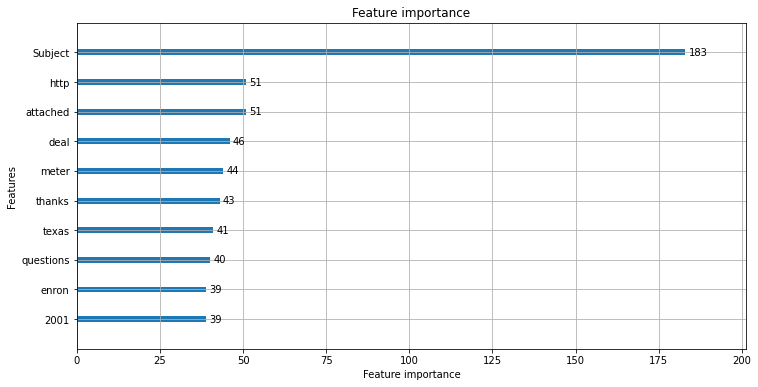

In [23]:
import matplotlib.pyplot as plt
lgb.plot_importance(gbm, figsize=(12, 6), max_num_features=10)
plt.show()

In [24]:
spam_rows = (df.label == '1')
spam_data = df[spam_rows]

count = 0
for i in spam_data['text']:
    count = count + i.count('subject')

print(count)

160


In [25]:
legit_rows = (df.label == '0')
legit_data = df[legit_rows]

count = 0
for i in legit_data['text']:
    count = count + i.count('subject')

print(count)

2733
